In [1]:
import os
import sys
train_done = True
study_id = 'original'
write_in_file = False

data_ = 'TransMut'

data_dir = '/home/s202357/thesis/transmut/data/transmut_github/'
model_folder = '/home/s202357/thesis/transmut/pipeline/{}/models/'.format(study_id)
result_folder = '/home/s202357/thesis/transmut/pipeline/{}/results/'.format(study_id)

In [2]:
!gpustat

phoebe                         Mon Jun 20 23:24:50 2022  470.103.01
[0] NVIDIA GeForce GTX 1080 Ti | 18'C,   0 % |     1 / 11178 MB |
[1] NVIDIA GeForce GTX 1080 Ti | 19'C,   0 % |     1 / 11178 MB |
[2] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |
[3] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |
[4] NVIDIA GeForce GTX 1080 Ti | 19'C,   0 % |     1 / 11178 MB |
[5] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |
[6] NVIDIA GeForce GTX 1080 Ti | 20'C,   0 % |     1 / 11178 MB |
[7] NVIDIA GeForce GTX 1080 Ti | 17'C,   0 % |     1 / 11178 MB |


In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [4]:
import math
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
import datetime
import random
random.seed(1234)

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from functools import reduce
from tqdm import tqdm, trange
import seaborn as sn
from copy import deepcopy
from scipy import spatial

from IPython.display import HTML
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

import gc
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data


In [5]:
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/functions')
sys.path.append('/home/s202357/thesis/transmut/pipeline/procedure/architecture')

import functions as fnc
from model_components import *

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print('There are %d GPU(s) avalable.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) avalable.


In [7]:
seed = 19961231
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [8]:
chart = [
[ ['1p', 'Blosum_ED', 20],           ['25p', 'Blosum_ED', 20],         ['75p', 'Blosum_ED', 20], ['100p', 'Blosum_ED', 20]],
[ ['1p', 'EmbeddingAttention', 4],   ['25p', 'EmbeddingAttention', 4],  ['75p', 'EmbeddingAttention', 4], ['100p', 'EmbeddingAttention', 4]],
[ ['1p', 'EmbeddingAttention', 20],  ['25p', 'EmbeddingAttention', 20], ['75p', 'EmbeddingAttention', 20], ['100p', 'EmbeddingAttention', 20]],    
[ ['1p', 'EmbeddingAttention', 32],  ['25p', 'EmbeddingAttention', 32], ['75p', 'EmbeddingAttention', 32], ['100p', 'EmbeddingAttention', 32]],
[ ['1p', 'EmbeddingAttention', 64],  ['25p', 'EmbeddingAttention', 64], ['75p', 'EmbeddingAttention', 64], ['100p', 'EmbeddingAttention', 64], ['100p', 'EmbeddingAttention', 128]]
]


blosum_dict = {
'A' : [5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0],
'R' : [-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3],
'N' : [-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3],
'D' : [-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4],
'C' : [-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1],
'Q' : [-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3],
'E' : [-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3],
'G' : [0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4],
'H' : [-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4],
'I' : [-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4],
'L' : [-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1],
'K' : [-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3],
'M' : [-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1],
'F' : [-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1],
'P' : [-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3],
'S' : [1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2],
'T' : [0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0],
'W' : [-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3],
'Y' : [-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1],
'V' : [0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5]
}


size_dict = {'1p':6000,
             '5p':30000,
             '25':150500,
             '50p':301000,
             '75':451500}

for key, val in zip(blosum_dict.keys(), blosum_dict.values()):
    if len(val) != 20:
        print(key +":"+ str(len(val)), end =", ")

In [9]:
cv = 5
count = 0
index_order = []

for outer in range(cv):
        test_idx = outer
        for inner in range(cv):
            if inner!=outer:
                val_idx = inner
                train_index = list()
                for t in range(5):
                    if t!=inner and t!=outer:
                        train_index.append(t)
                count += 1  
                index_order.append([test_idx, val_idx, train_index])
                
index_order_nested = index_order


In [10]:
pep_max_len = 14
hla_max_len = 34

tgt_len = pep_max_len + hla_max_len

d_ff = 512
n_layers, n_heads = 1, 3

batch_size = 1024
epochs = 25
threshold = 0.5

vocab = np.load( data_dir + 'Transformer_vocab_dict.npy', allow_pickle = True).item()
vocab_size = len(vocab)

model_info = chart[4][3]
size = model_info[0]   
model_type = model_info[1]
d_model = d_k = d_v = model_info[2]
model_abbr = 'ED'

print(size, model_type, d_model)

id_blosum = 'OF_TData_pad14_{}_{}_hlac_pad'
id_emb = 'OF_TData_pad14_{}_{}'
#id_emb = 'OF_TData_pad14_{}_EmbeddingAttention_200ep'

save_attn = False
save_attn_hla = True


100p EmbeddingAttention 64


SET PARAMETERS AND MODEL TO GET FIGURES

In [11]:
 if "Blosum" in model_type:
            id_nested = id_blosum.format(size, model_type)  
            encoding_ = 'blosum'

            class EncoderLayer(nn.Module):
                def __init__(self):
                    super(EncoderLayer, self).__init__()
                    self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, enc_inputs, enc_self_attn_mask):
                    enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
                    enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
                    return enc_outputs, attn


            class Encoder(nn.Module):
                def __init__(self):
                    super(Encoder, self).__init__()
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

                def forward(self, enc_inputs):
                    enc_outputs = self.pos_emb(enc_inputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
                        
                    #print("\n\n\n\n\nshape enc_inputs-------")
                    #print("np.shape(enc_inputs)", np.shape(enc_inputs))
                    #print("type enc_inputs", type(enc_inputs))
                    #for i in enc_inputs[0]:
                    #    print(i)
                    
                    seq_q_pad = torch.from_numpy( np.array( [ [np.prod(aa) for aa in pep] for pep in np.array(enc_inputs.cpu())] )).to(device)
                    
                    
                    #print("np.shape(seq_q)", np.shape(seq_q), "-------")
                    #print("type (seq_q)", type(seq_q), "-------")
                    
                    #for i in seq_q[0]:
                    #    print(i)
                        
                    enc_self_attn_mask = fnc.get_attn_pad_mask_blosum(seq_q_pad, seq_q_pad) # [batch_size, src_len, src_len]
                        
                    del seq_q
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    #print("shape enc_self_attn_mask", np.shape(enc_self_attn_mask), "----------")
                    #for i in enc_self_attn_mask[0]:
                    #    print(i)
                    
                    enc_self_attns = []
                    for layer in self.layers:
                        enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
                        enc_self_attns.append(enc_self_attn)
                    return enc_outputs, enc_self_attns

            class DecoderLayer(nn.Module):
                def __init__(self):
                    super(DecoderLayer, self).__init__()
                    self.dec_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, dec_inputs, dec_self_attn_mask): 
                    dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
                    dec_outputs = self.pos_ffn(dec_outputs)
                    return dec_outputs, dec_self_attn


            class Decoder(nn.Module):
                def __init__(self):
                    super(Decoder, self).__init__()
                    self.use_cuda = use_cuda
                    device = torch.device('cuda')
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
                    self.tgt_len = tgt_len

                def forward(self, dec_inputs): 
                    dec_outputs = self.pos_emb(dec_inputs.transpose(0, 1)).transpose(0, 1).to(device) # [batch_size, tgt_len, d_model]
                    dec_self_attn_pad_mask = torch.LongTensor(np.zeros((dec_inputs.shape[0], tgt_len, tgt_len))).bool().to(device)

                    dec_self_attns = []
                    for layer in self.layers:
                        dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_pad_mask)
                        dec_self_attns.append(dec_self_attn)

                    return dec_outputs, dec_self_attns
            print("Transformer Blosum imported")
            
if "Embedding" in model_type:
            
            id_nested = id_emb.format(size, model_type)
            encoding_ = 'embedding'
            
            class EncoderLayer(nn.Module):
                def __init__(self):
                    super(EncoderLayer, self).__init__()
                    self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, enc_inputs, enc_self_attn_mask):
                    enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
                    enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
                    return enc_outputs, attn


            class Encoder(nn.Module):
                def __init__(self):
                    super(Encoder, self).__init__()
                    self.src_emb = nn.Embedding(vocab_size, d_model)
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

                def forward(self, enc_inputs):
                    enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]
                    '''
                    print("---------")
                    print("---------")
                    if len(enc_outputs[0]) == 14:
                        for i, t in zip(enc_inputs[0], enc_outputs[0]):
                            print("\'" + str(list(vocab.keys())[i.item()-1]) + "\':" , t.tolist())
                    print("---------")
                    print("---------")
                    print("---------")
                    '''
                    enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
                    enc_self_attn_mask = fnc.get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
                    
                    #print("\n\nshape enc_inputs-------")
                    #print("np.shape(enc_inputs)", np.shape(enc_inputs))
                    #for i in enc_inputs[0]:
                    #    print(i)
                    
                    enc_self_attns = []
                    for layer in self.layers:
                        enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
                        enc_self_attns.append(enc_self_attn)
                    return enc_outputs, enc_self_attns
            print("Transformer Embedding imported")
            
        
            class DecoderLayer(nn.Module):
                def __init__(self):
                    super(DecoderLayer, self).__init__()
                    self.dec_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
                    self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

                def forward(self, dec_inputs, dec_self_attn_mask): 
                    '''
                    dec_inputs: [batch_size, tgt_len, d_model]
                    enc_outputs: [batch_size, src_len, d_model]
                    dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
                    '''
                    dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
                    dec_outputs = self.pos_ffn(dec_outputs) 
                    return dec_outputs, dec_self_attn


            class Decoder(nn.Module):
                def __init__(self):
                    super(Decoder, self).__init__()
                    self.use_cuda = use_cuda
                    device = torch.device('cuda')
                    self.pos_emb = PositionalEncoding(d_model)
                    self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
                    self.tgt_len = tgt_len

                def forward(self, dec_inputs): 
                    '''
                    dec_inputs: [batch_size, tgt_len]
                    enc_intpus: [batch_size, src_len]
                    enc_outputs: [batsh_size, src_len, d_model]
                    '''
                    dec_outputs = self.pos_emb(dec_inputs.transpose(0, 1)).transpose(0, 1).to(device) 
                    dec_self_attn_pad_mask = torch.LongTensor(np.zeros((dec_inputs.shape[0], tgt_len, tgt_len))).bool().to(device)

                    dec_self_attns = []
                    for layer in self.layers:
                        dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_pad_mask)
                        dec_self_attns.append(dec_self_attn)

                    return dec_outputs, dec_self_attns
                
                
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.use_cuda = use_cuda
        device = torch.device('cuda')
        self.pep_encoder = Encoder().to(device)
        self.hla_encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.tgt_len = tgt_len
        self.projection = nn.Sequential(
                                        nn.Linear(tgt_len * d_model, 256),
                                        nn.ReLU(True),

                                        nn.BatchNorm1d(256),
                                        nn.Linear(256, 64),
                                        nn.ReLU(True),

                                        #output layer
                                        nn.Linear(64, 2)
                                        ).to(device)
        
    def forward(self, pep_inputs, hla_inputs):
        '''
        pep_inputs: [batch_size, pep_len]
        hla_inputs: [batch_size, hla_len]
        '''
        pep_enc_outputs, pep_enc_self_attns = self.pep_encoder(pep_inputs)
        hla_enc_outputs, hla_enc_self_attns = self.hla_encoder(hla_inputs)
        enc_outputs = torch.cat((pep_enc_outputs, hla_enc_outputs), 1) # concat pep & hla embedding
        
        dec_outputs, dec_self_attns = self.decoder(enc_outputs)
        dec_outputs = dec_outputs.view(dec_outputs.shape[0], -1) # Flatten [batch_size, tgt_len * d_model]
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]

        return dec_logits.view(-1, dec_logits.size(-1)), pep_enc_self_attns, hla_enc_self_attns, dec_self_attns

Transformer Embedding imported


TEST MODEL

In [12]:
auc_list = []
auc01_list = []
ppv_list = []

In [13]:
print('\n\n\n===== Model {}, {}, {} ====='.format(size,model_type,d_model))

ep_best = 0
fold = 0

test_fold_metrics_list_nested = []

fold_avg_4 = True
type_ = 'test'

df_list = []
time_testing = time.time()

if fold_avg_4:

    fold_avg_all = [list(range(0,4)), list(range(4,8)), list(range(8,12)), list(range(12,16)), list(range(16,20))] 
    pred_all = []
    target_all = []
    enc_attn_list_all = []
    enc_hla_attn_list_all = []
    
    for fold_avg, file_num in zip(fold_avg_all,[0,1,2,3,4]):

            pred_fold = []
            target_fold = []
            enc_attn_list_tmp = []
            enc_hla_attn_list_tmp = []

            #print('\n=====Models-{}====='.format(fold_avg))
            for f in fold_avg:
                index_order_idx = f
                path_saver = model_folder + fnc.pkl(id_nested, n_layers, n_heads, f, d_model)
                print("\t"+path_saver.replace("/home/s202357/thesis/transmut/pipeline/original/models/",""))

                test_data, test_pep_inputs, test_hla_inputs, test_labels, test_loader = fnc.data_with_loader_unique(data_dir, 
                                                                                                                    model_type, 
                                                                                                                    pep_max_len,
                                                                                                                    hla_max_len,
                                                                                                                    vocab,
                                                                                                                    index_order_idx, 
                                                                                                                    type_ = type_, 
                                                                                                                    fold = file_num,  
                                                                                                                    batch_size = batch_size)
                model = Transformer().to(device)

                model.load_state_dict(torch.load(path_saver))
                model_test = model.eval()

                ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin, enc_attn_list, enc_hla_attn_list = fnc.eval_step_test(model_test, 
                                                                                                       model_abbr,
                                                                                                       threshold,
                                                                                                       test_loader, 
                                                                                                       fold, 
                                                                                                       ep_best, 
                                                                                                       epochs, 
                                                                                                       use_cuda) # , test_res_attns
                pred_fold.append(y_prob)
                target_fold = [x.item() for x in test_labels]

                df_temp = pd.DataFrame(list(zip(target_fold, y_prob)), columns= ['target_', 'pred_'])
                num_pos = len(df_temp[df_temp['target_']==1])
                df_temp_ppv = df_temp.sort_values(by=['pred_'], ascending=False)[0:num_pos]
                num_true_pos = len(df_temp_ppv[df_temp_ppv['target_']==1])
                ppv = num_true_pos/num_pos
                auc_01 = fnc.binary_roc_auc_score(df_temp['target_'].tolist(), df_temp['pred_'], max_fpr=0.1)
                auc01_ppv = (auc_01, ppv)
                metrics_final = (*auc01_ppv, *metrics_res_test)

                test_fold_metrics_list_nested.append(metrics_final)
                
                if save_attn:
                    enc_attn_list_tmp.append(enc_attn_list)
                if save_attn_hla:
                    enc_hla_attn_list_tmp.append(enc_hla_attn_list)
                
                del test_pep_inputs, test_hla_inputs, test_labels, test_loader, model, ys_res_test, loss_res_test_list, metrics_res_test, y_prob, y_pred_bin
                gc.collect()
                torch.cuda.empty_cache()
                print("")

            #print("\t\tTaking the average:")   
            # get avg of attn
            if save_attn:
                enc_attn_list_mean = np.mean(enc_attn_list_tmp, axis=0)
                enc_attn_list_all.extend(enc_attn_list_mean)
                del enc_attn_list_tmp, enc_attn_list_mean
                gc.collect()
            if save_attn_hla:
                enc_hla_attn_list_mean = np.mean(enc_hla_attn_list_tmp, axis=0)
                enc_hla_attn_list_all.extend(enc_hla_attn_list_mean)            
            
            arrays = [np.array(x) for x in pred_fold]
            pred_fold_avg = [np.mean(k) for k in zip(*arrays)]
            pred_all.extend(pred_fold_avg)
            target_all.extend(target_fold)
            print("\t\t\t\t roc in:", roc_auc_score(target_fold, pred_fold_avg))

            test_data['target_'] = target_fold
            test_data['pred_'] = pred_fold_avg
            df_list.append(test_data)

    df_pd_nested_test_unique = pd.concat(df_list)
    del df_list
    gc.collect()




===== Model 100p, EmbeddingAttention, 64 =====
	OF_TData_pad14_100p_EmbeddingAttention_d64_layer1_multihead3_MODEL0.pkl
	Test File ID 0 372896 torch.Size([372896, 14])

	OF_TData_pad14_100p_EmbeddingAttention_d64_layer1_multihead3_MODEL1.pkl
	Test File ID 0 372896 torch.Size([372896, 14])

	OF_TData_pad14_100p_EmbeddingAttention_d64_layer1_multihead3_MODEL2.pkl
	Test File ID 0 372896 torch.Size([372896, 14])

	OF_TData_pad14_100p_EmbeddingAttention_d64_layer1_multihead3_MODEL3.pkl
	Test File ID 0 372896 torch.Size([372896, 14])

				 roc in: 0.9817994771565939
	OF_TData_pad14_100p_EmbeddingAttention_d64_layer1_multihead3_MODEL4.pkl
	Test File ID 1 372782 torch.Size([372782, 14])

	OF_TData_pad14_100p_EmbeddingAttention_d64_layer1_multihead3_MODEL5.pkl
	Test File ID 1 372782 torch.Size([372782, 14])

	OF_TData_pad14_100p_EmbeddingAttention_d64_layer1_multihead3_MODEL6.pkl
	Test File ID 1 372782 torch.Size([372782, 14])

	OF_TData_pad14_100p_EmbeddingAttention_d64_layer1_multihead3_MO

In [14]:
df_results = pd.DataFrame(list(zip(target_all, pred_all)), columns= ['target', 'pred'])

del model_test, target_all, pred_all, Transformer
gc.collect()
torch.cuda.empty_cache()

In [15]:
#print("Time testing:", round((time.time()-time_testing)/60, 2), "mins. \n\n")
print(model_info)
print("== Stats:")
auc_ = roc_auc_score(df_results['target'], df_results['pred'])
print("  auc:", auc_)

num_pos = len(df_results[df_results['target']==1])
df_temp_ppv = df_results.sort_values(by=['pred'], ascending=False)[0:num_pos]
num_true_pos = len(df_temp_ppv[df_temp_ppv['target']==1])
ppv = num_true_pos/num_pos
auc_01 = fnc.binary_roc_auc_score(df_results['target'].tolist(), df_results['pred'].tolist(), max_fpr=0.1)
print("  auc fpr 0.1:", auc_01)
print("  ppv:", ppv)

acc_best, i, df_results = fnc.best_treshold(df_results, [0.5])
print("  Used/Best treshold:", i, "\n")
print("  AUC pred treshold:", roc_auc_score(df_results['target'], df_results['pred_binary']))
roc_auc, acc, mcc, f1, sensitivity, specificity, precision, recall, aupr = fnc.performances(df_results['target'], df_results['pred_binary'], df_results['pred'], print_ = True)

del df_results
gc.collect()

['100p', 'EmbeddingAttention', 64]
== Stats:
  auc: 0.9814548469753153
  auc fpr 0.1: 0.8683893995397715
  ppv: 0.8728721538230233
  Used/Best treshold: 0.5 

  AUC pred treshold: 0.9344769844719177
tn = 1410586, fp = 94868, fn = 24434, tp = 334732
y_pred: 0 = 1435020 | 1 = 429600
y_true: 0 = 1505454 | 1 = 359166
auc=0.9815|sensitivity=0.9320|specificity=0.9370|acc=0.9360|mcc=0.8138
precision=0.7792|recall=0.9320|f1=0.8487|aupr=0.9379


0

In [16]:
def aa_spec_attn(data, attn, max_len, label, pep_len = None, HLA_type = None, fltr = None):
        
    aa_spec_attn = np.zeros((20,max_len,max_len))
    head_mean = np.array(attn).mean(axis=1)
    
    if fltr:
        data = data[0:fltr[0]]
        head_mean = head_mean[0:fltr[0]]
        
    cc = 0
    for attn, peptide, hla, lbl in zip(head_mean, data['peptide'].tolist(), data['HLA'].tolist(), data['label'].tolist()):
        if HLA_type == None:
            hla = None
        if lbl == label and hla == HLA_type and len(peptide) in pep_len:
            cc += 1
            for aa, idx in zip(peptide, list(range(len(peptide)))):
                attn_row = attn[idx]
                aa_spec_attn[aas_dict[aa]][idx] = aa_spec_attn[aas_dict[aa]][idx] + attn_row
        else:
            continue

    print(cc)        
    return aa_spec_attn / cc*10

def plot_attn(df, attn, idx):
    print(df[['peptide','length','HLA','label']][idx:idx+1])
    return sn.heatmap(attn,cmap='YlGnBu')

## Attention MHC & 100p 64d

In [17]:
from scipy import spatial

def corrcoef_aas(repr_dict, HLA_list, norm = None, pearson= True):
    tbl = []
    for HLA_filter_1 in HLA_list:
        row = []
        #print(HLA_filter_1 + ", ", end="")
        for HLA_filter_2 in HLA_list:
            X = repr_dict[HLA_filter_1]
            Y = repr_dict[HLA_filter_2]
            if pearson:
                #method 1:
                pearson = np.corrcoef(X, Y)[0][1] 
                if norm:
                    pearson = round(pearson * norm)
                row.append(pearson)
            else:
                #method 2:
                cos = (1 - spatial.distance.cosine(X, Y))
                if norm:
                    cos = round(cos * norm)
                row.append(cos)
        gc.collect()
        tbl.append(row)
    return tbl

def cluster_HLA(col_mean_per_HLA):
    tbl = corrcoef_aas(col_mean_per_HLA, col_mean_per_HLA.keys(), norm = None, pearson = True)
    tbl = pd.DataFrame(tbl)
    tbl.columns = col_mean_per_HLA.keys()
    tbl = tbl.set_axis(col_mean_per_HLA.keys(), axis='index').sort_index(ascending=True)
    return tbl

In [18]:
print(path_saver)

/home/s202357/thesis/transmut/pipeline/original/models/OF_TData_pad14_100p_EmbeddingAttention_d64_layer1_multihead3_MODEL19.pkl


In [19]:
enc_hla_attn_list_all = torch.from_numpy(np.array(enc_hla_attn_list_all))
HLA_list = list(set(df_pd_nested_test_unique.reset_index(drop=True)['HLA'].tolist()))

In [20]:
df_pd_nested_test_unique.reset_index(drop=True)

peptide  length          HLA  label  \
0          HLNRTLAEN       9  HLA-B*15:01      0   
1           SDADCPTC       8  HLA-C*07:01      0   
2        LKRMSVYVILV      11  HLA-B*58:01      0   
3          MPSVFQNVL       9  HLA-C*04:01      1   
4          TPSSREGTL       9  HLA-B*07:02      1   
...              ...     ...          ...    ...   
1864615    QGDGEDNHM       9  HLA-C*02:02      0   
1864616     FTSAEDDE       8  HLA-B*15:01      0   
1864617    TATTPTATS       9  HLA-B*14:02      0   
1864618    RGASGSIFS       9  HLA-C*03:03      0   
1864619  PAMFTEPANDT      11  HLA-B*15:01      0   

                               HLA_sequence  target_     pred_  
0        YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY        0  0.002293  
1        YDSGYRENYRQADVSNLYLRYDSYTLAALAYTWY        0  0.000062  
2        YYATYGENMASTYENIAYIRYDSYTWAVLAYLWY        0  0.000575  
3        YSAGYREKYRQADVNKLYLRFNFYTWAERAYTWY        1  0.969817  
4        YYSEYRNIYAQTDESNLYLSYDYYTWAERAYEWY        1  0.996851  
...                                     ...      ...       ...  
1864615  YYAGYREKYRQTDVNKLYLRYDSYTWAEWAYEWY        0  0.005793  
1864616  YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY        0  0.010387  
1864617  YYSEYRNICTNTDESNLYLWYNFYTWAELAYTWH        0  0.000144  
1864618  YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY        0  0.000518  
1864619  YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY        0  0.002169  

[1864620 rows x 7 columns]

In [21]:
col_mean_per_HLA = dict()
col_mean_per_HLA_softmax = dict()

for HLA_filter in HLA_list:
    softmax_pd, unsoftmax_pd, max_list, new_pseudo =  fnc.draw_hla_length_aatype_position_HLApseudo(17, 10, '#9fc2b9', df_pd_nested_test_unique.reset_index(drop=True), enc_hla_attn_list_all, n_heads, HLA_filter, 34, softmax_dim = 0, label = 1 , length = None , threshold = 0.60, show = None, top = False, softmax = True, unsoftmax = True )    
    print(color.END + '')
    col_mean_per_HLA[HLA_filter] =  unsoftmax_pd.max(axis=0).tolist()
    col_mean_per_HLA_softmax[HLA_filter] =  softmax_pd.max(axis=0).tolist()
    print("---------------------")


#Peptides: 2550
HLA: HLA-B*27:02
Threshold: 0.6
YHTEYREICAKTDENIAYLNYHDYTWAVLAYEWY
---------------------
#Peptides: 4409
HLA: HLA-B*40:01
Threshold: 0.6
YHTKYREISTNTYESNLYLRYNYYSLAVLAYEWY
---------------------
#Peptides: 1263
HLA: HLA-B*39:06
Threshold: 0.6
YYSEYRNICTNTDESNLYWTYNFYTWAVLTYTWY
---------------------
#Peptides: 1648
HLA: HLA-B*27:08
Threshold: 0.6
YHTEYREICAKTDESNLYLNYHDYTWAVLAYEWY
---------------------
#Peptides: 96
HLA: HLA-A*25:01
Threshold: 0.6
YYAMYRNNVAHTDESIAYIRYQDYTWAEWAYRWY
---------------------
#Peptides: 4974
HLA: HLA-B*51:01
Threshold: 0.6
YYATYRNIFTNTYENIAYWTYNYYTWAELAYLWH
---------------------
#Peptides: 1617
HLA: HLA-C*12:03
Threshold: 0.6
YYAGYREKYRQADVSNLYLWYDSYTWAEWAYTWY
---------------------
#Peptides: 327
HLA: HLA-B*15:03
Threshold: 0.6
YYSEYREISTNTYESNLYLRYDSYTWAELAYLWY
---------------------
#Peptides: 1627
HLA: HLA-B*27:07
Threshold: 0.6
YHTEYREICAKTDEDTLYLSYNYYTWAVLAYEWY
---------------------
#Peptides: 5447
HLA: HLA-C*06:02
Threshold: 0.6
YDSGYREKYR

In [216]:
tbl_cluster_sim = cluster_HLA(col_mean_per_HLA_softmax)
tbl_cluster_sim

HLA-B*27:02  HLA-B*40:01  HLA-B*39:06  HLA-B*27:08  HLA-A*25:01  \
HLA-A*01:01     0.506163     0.352501     0.349695     0.480283     0.462784   
HLA-A*02:01     0.415372     0.722817     0.212579     0.471826     0.321620   
HLA-A*02:02     0.428123     0.771016     0.288698     0.477974     0.403865   
HLA-A*02:03     0.421309     0.724677     0.208153     0.476271     0.345168   
HLA-A*02:04     0.451938     0.674560     0.241339     0.511054     0.294099   
...                  ...          ...          ...          ...          ...   
HLA-C*12:03     0.451688     0.554920     0.434382     0.462111     0.686201   
HLA-C*14:02     0.415312     0.556784     0.322629     0.435091     0.484927   
HLA-C*15:02     0.562586     0.421566     0.368781     0.381590     0.947106   
HLA-C*16:01     0.394781     0.641741     0.510563     0.406899     0.635232   
HLA-C*17:01     0.517278     0.474931     0.435668     0.361837     0.741993   

             HLA-B*51:01  HLA-C*12:03  HLA-B*15:03  HLA-B*27:07  HLA-C*06:02  \
HLA-A*01:01     0.112068     0.456515     0.368165     0.552283     0.520056   
HLA-A*02:01     0.259385     0.505853     0.468730     0.591703     0.535395   
HLA-A*02:02     0.327703     0.540148     0.504390     0.594992     0.567269   
HLA-A*02:03     0.262877     0.506092     0.464614     0.565413     0.538067   
HLA-A*02:04     0.264774     0.438276     0.507007     0.598241     0.474299   
...                  ...          ...          ...          ...          ...   
HLA-C*12:03     0.348595     1.000000     0.647345     0.502939     0.806021   
HLA-C*14:02     0.215542     0.817503     0.455121     0.495847     0.706625   
HLA-C*15:02     0.462372     0.659006     0.536743     0.324750     0.706496   
HLA-C*16:01     0.413233     0.964643     0.692451     0.483560     0.771802   
HLA-C*17:01     0.402187     0.698813     0.503115     0.269552     0.724652   

             ...  HLA-A*03:01  HLA-B*15:02  HLA-C*14:02  HLA-A*02:11  \
HLA-A*01:01  ...     0.918963     0.390994     0.491060     0.494969   
HLA-A*02:01  ...     0.631363     0.513431     0.490420     0.913701   
HLA-A*02:02  ...     0.663239     0.565259     0.469436     0.879681   
HLA-A*02:03  ...     0.608300     0.509703     0.441270     0.907205   
HLA-A*02:04  ...     0.611297     0.479120     0.411035     0.904512   
...          ...          ...          ...          ...          ...   
HLA-C*12:03  ...     0.544239     0.753706     0.817503     0.514403   
HLA-C*14:02  ...     0.508876     0.598886     1.000000     0.458222   
HLA-C*15:02  ...     0.532674     0.670127     0.525321     0.244443   
HLA-C*16:01  ...     0.525546     0.815616     0.784712     0.527748   
HLA-C*17:01  ...     0.387762     0.609478     0.587006     0.252355   

             HLA-B*57:03  HLA-B*15:17  HLA-C*16:01  HLA-A*68:02  HLA-B*27:06  \
HLA-A*01:01     0.488818     0.498952     0.414819     0.477525     0.394088   
HLA-A*02:01     0.467928     0.338948     0.568868     0.466724     0.563740   
HLA-A*02:02     0.539441     0.362494     0.610267     0.548720     0.575653   
HLA-A*02:03     0.467823     0.333668     0.568046     0.481868     0.572373   
HLA-A*02:04     0.454733     0.314664     0.498332     0.442135     0.604391   
...                  ...          ...          ...          ...          ...   
HLA-C*12:03     0.397334     0.599332     0.964643     0.656330     0.364452   
HLA-C*14:02     0.243647     0.435424     0.784712     0.453168     0.342102   
HLA-C*15:02     0.684065     0.878131     0.613978     0.784162     0.317181   
HLA-C*16:01     0.444390     0.583073     1.000000     0.638090     0.326300   
HLA-C*17:01     0.426877     0.637042     0.673507     0.524803     0.248301   

             HLA-A*02:16  
HLA-A*01:01     0.533310  
HLA-A*02:01     0.996860  
HLA-A*02:02     0.958827  
HLA-A*02:03     0.985717  
HLA-A*02:04     0.985532  
...                  ...  
HLA-C*12:03     0.495928  
HLA-C*14:02     0.479336  
HLA-C*15:02     0.2562

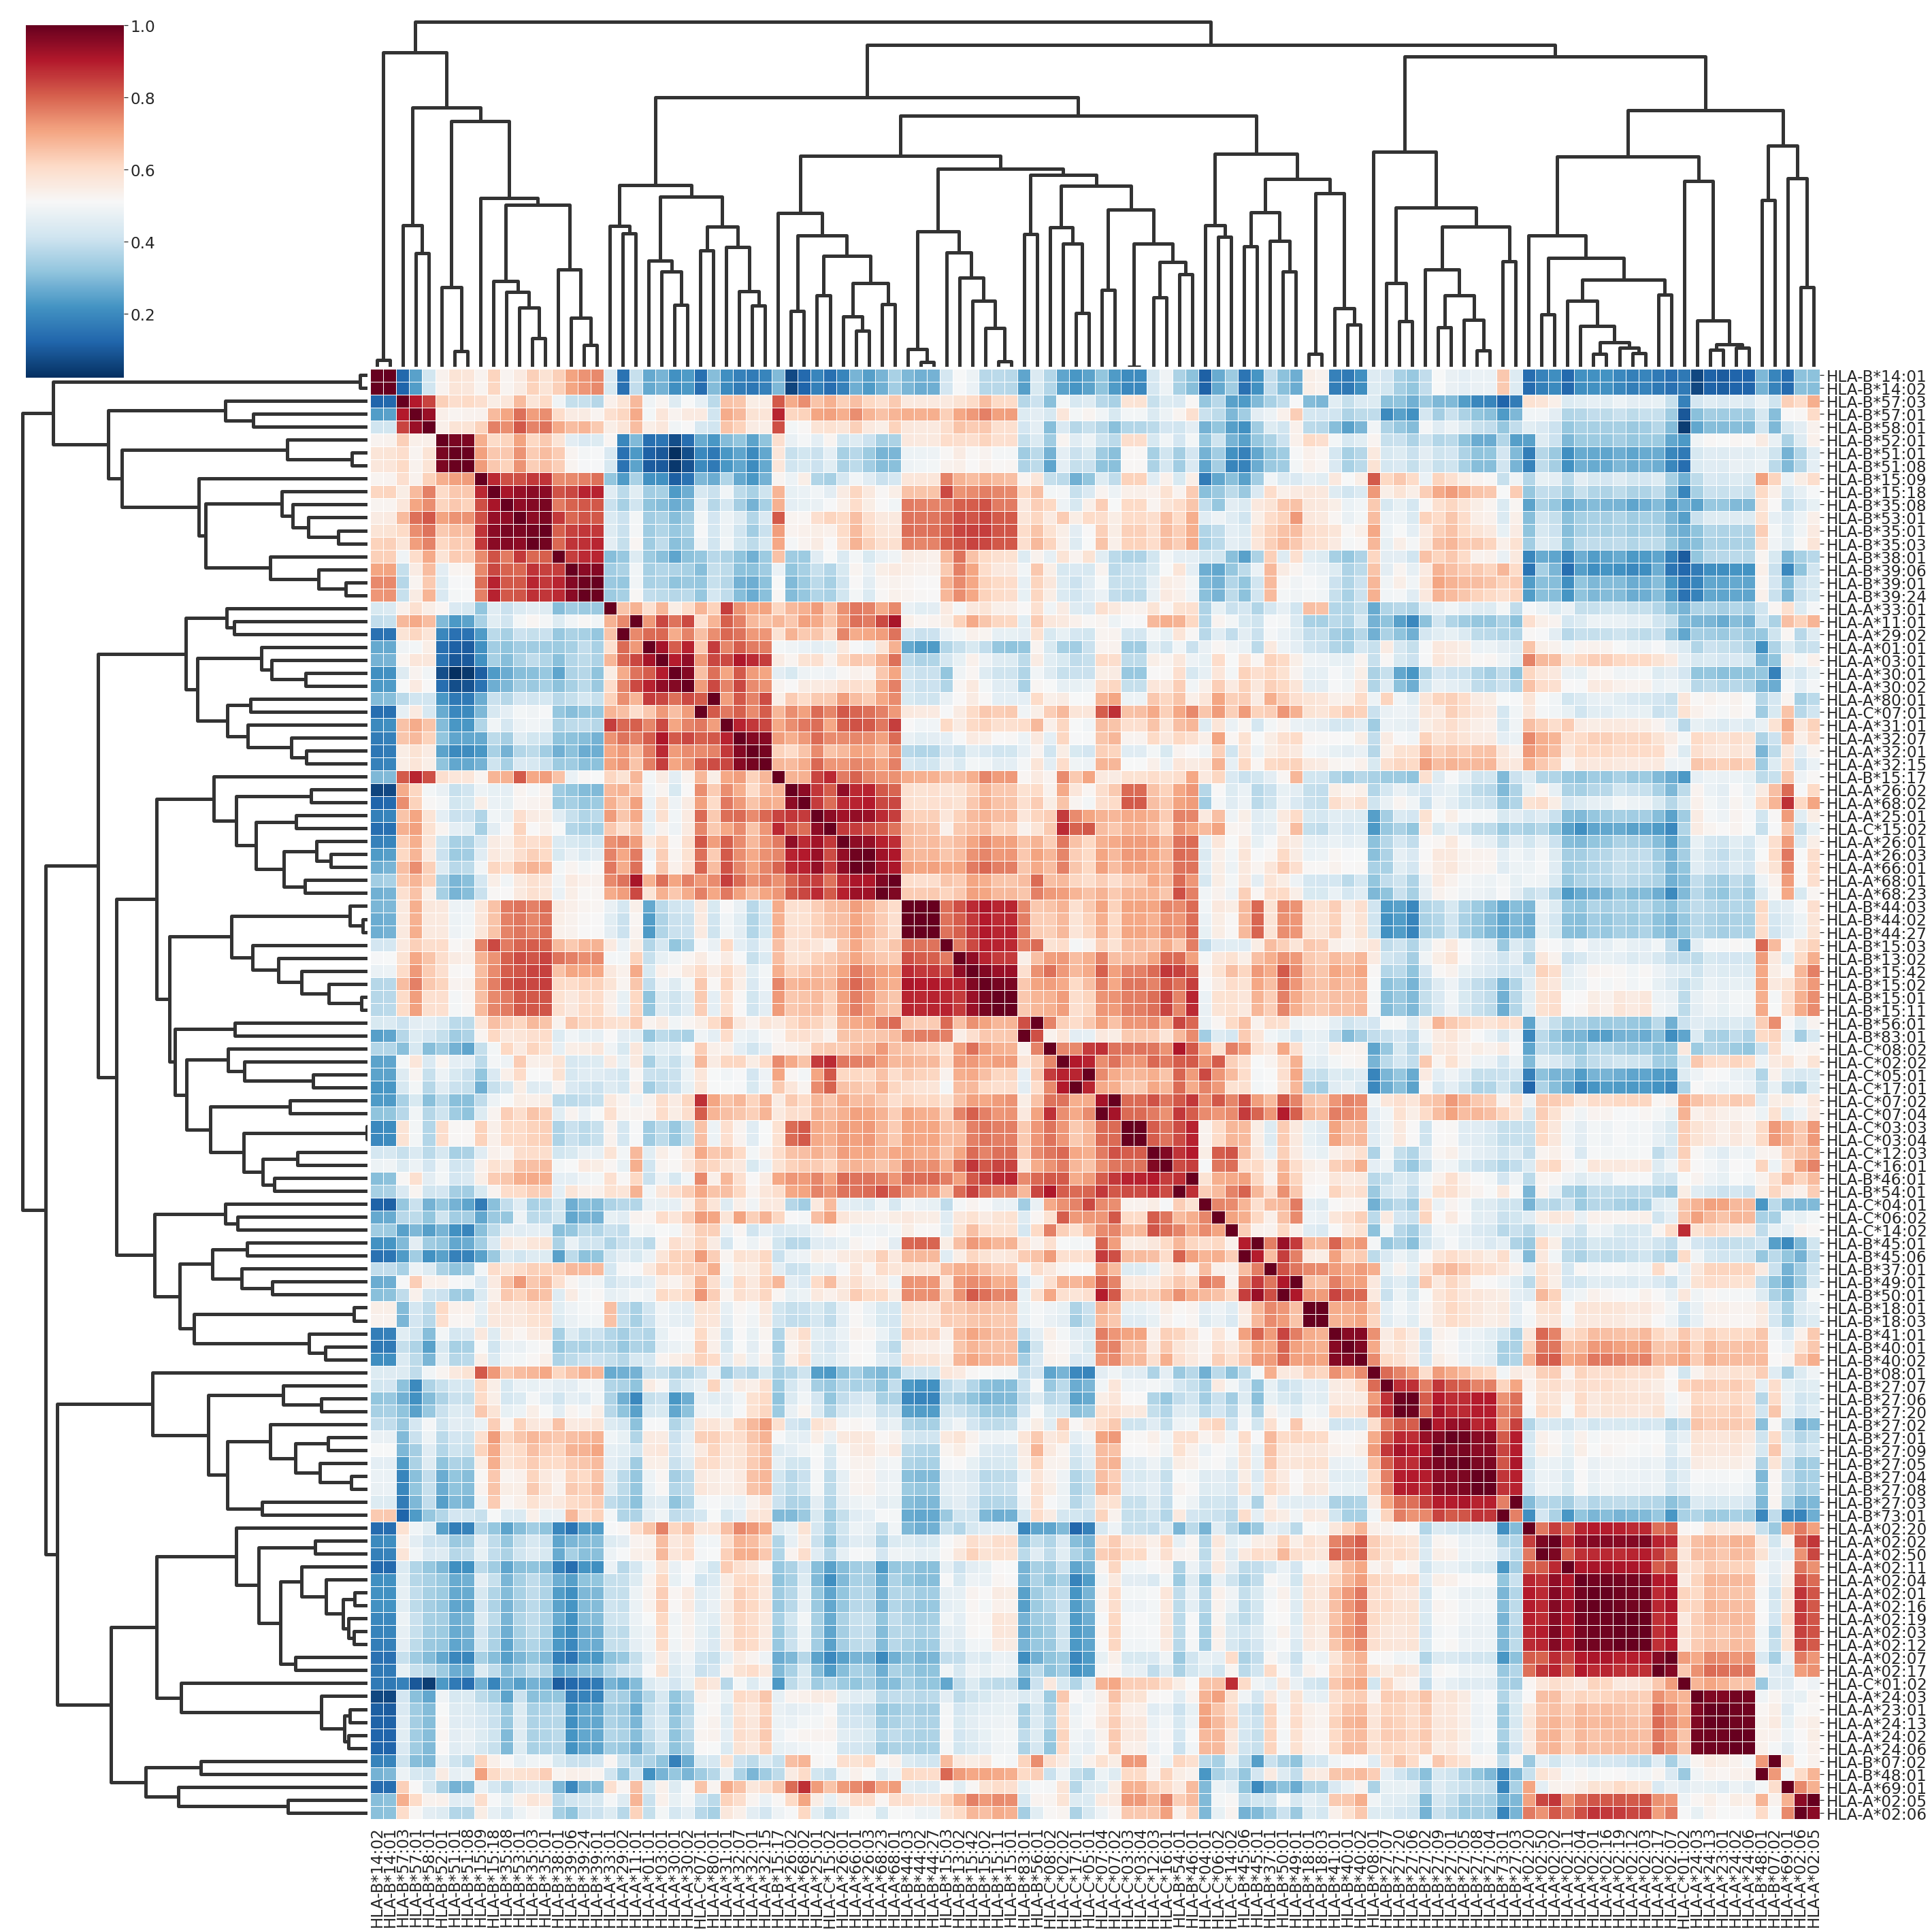

In [24]:
sn.set(font_scale=2.1)
g = sn.clustermap(tbl_cluster_sim, cmap='RdBu_r', linewidths=0.5, figsize=(40, 40), xticklabels=True, yticklabels=True, annot_kws={"size": 36})
for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(5)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(5)

In [213]:
index_order = [str(x)[-13:-2] for x in g.ax_heatmap.get_yticklabels()]
index_order

['HLA-B*14:02',
 'HLA-B*14:01',
 'HLA-B*57:03',
 'HLA-B*58:01',
 'HLA-B*57:01',
 'HLA-B*52:01',
 'HLA-B*51:01',
 'HLA-B*51:08',
 'HLA-B*15:09',
 'HLA-B*15:18',
 'HLA-B*35:08',
 'HLA-B*53:01',
 'HLA-B*35:01',
 'HLA-B*35:03',
 'HLA-B*38:01',
 'HLA-B*39:06',
 'HLA-B*39:01',
 'HLA-B*39:24',
 'HLA-A*33:01',
 'HLA-A*11:01',
 'HLA-A*29:02',
 'HLA-A*01:01',
 'HLA-A*03:01',
 'HLA-A*30:01',
 'HLA-A*30:02',
 'HLA-A*80:01',
 'HLA-C*07:01',
 'HLA-A*31:01',
 'HLA-A*32:07',
 'HLA-A*32:15',
 'HLA-A*32:01',
 'HLA-B*15:17',
 'HLA-A*68:02',
 'HLA-A*26:02',
 'HLA-A*25:01',
 'HLA-C*15:02',
 'HLA-A*26:01',
 'HLA-A*66:01',
 'HLA-A*26:03',
 'HLA-A*68:01',
 'HLA-A*68:23',
 'HLA-B*44:03',
 'HLA-B*44:02',
 'HLA-B*44:27',
 'HLA-B*15:03',
 'HLA-B*13:02',
 'HLA-B*15:42',
 'HLA-B*15:02',
 'HLA-B*15:01',
 'HLA-B*15:11',
 'HLA-B*56:01',
 'HLA-B*83:01',
 'HLA-C*08:02',
 'HLA-C*02:02',
 'HLA-C*05:01',
 'HLA-C*17:01',
 'HLA-C*07:04',
 'HLA-C*07:02',
 'HLA-C*03:04',
 'HLA-C*03:03',
 'HLA-C*16:01',
 'HLA-C*12:03',
 'HLA-B*

In [26]:
pos_imp_hla = pd.DataFrame(list(col_mean_per_HLA_softmax.values())).set_axis(col_mean_per_HLA_softmax.keys(), axis='index').reindex(index_order)
pos_imp_hla


0       1       2       3       4       5       6       7   \
HLA-B*14:01  0.1489  0.1440  0.5184  0.1948  0.1484  0.2601  0.2024  0.7938   
HLA-B*14:02  0.1527  0.1466  0.5294  0.1922  0.1504  0.2514  0.2003  0.7957   
HLA-B*57:03  0.1784  0.1725  0.3043  0.7484  0.1785  1.0000  0.2866  0.1891   
HLA-B*57:01  0.1716  0.1665  0.2767  0.8479  0.1695  1.0000  0.2458  0.1918   
HLA-B*58:01  0.1585  0.1542  0.2758  0.4585  0.1585  1.0000  0.2108  0.1760   
...             ...     ...     ...     ...     ...     ...     ...     ...   
HLA-B*07:02  0.1903  0.1810  0.5188  0.2017  0.1830  0.2143  0.2223  0.9519   
HLA-B*48:01  0.2092  0.1952  0.6360  0.3684  0.1986  0.3173  0.2654  0.9419   
HLA-A*69:01  0.1885  0.1773  0.3746  0.8471  0.1852  0.4706  0.2843  0.2320   
HLA-A*02:05  0.1745  0.1661  0.3347  0.8676  0.1674  0.9995  0.1960  0.9946   
HLA-A*02:06  0.1750  0.1665  0.3520  0.8651  0.1688  0.9996  0.2045  0.9980   

                 8       9   ...      24      25      26      27      28  \
HLA-B*14:01  0.9774  0.2611  ...  0.2222  0.5347  0.2379  0.2660  0.6624   
HLA-B*14:02  0.9808  0.2524  ...  0.2177  0.5423  0.2295  0.2541  0.6436   
HLA-B*57:03  0.5194  0.3341  ...  0.2615  0.7943  0.2084  0.2876  0.7784   
HLA-B*57:01  0.5971  0.3081  ...  0.2371  0.7027  0.1977  0.3864  0.7354   
HLA-B*58:01  0.9529  0.3136  ...  0.2208  0.6804  0.1868  0.4103  0.6676   
...             ...     ...  ...     ...     ...     ...     ...     ...   
HLA-B*07:02  0.2061  0.4956  ...  0.3698  0.8443  0.3014  0.2708  0.3432   
HLA-B*48:01  0.1554  0.6209  ...  0.3735  0.6101  0.3262  0.8793  0.8654   
HLA-A*69:01  0.2197  0.4571  ...  0.2616  0.8487  0.2415  0.3078  0.8921   
HLA-A*02:05  0.1885  0.4822  ...  0.2241  0.6846  0.2382  0.2810  0.9920   
HLA-A*02:06  0.1727  0.4888  ...  0.2250  0.8359  0.2388  0.2640  0.8436   

                 29      30      31      32      33  
HLA-B*14:01  0.3329  0.1550  0.3331  0.7995  0.9980  
HLA-B*14:02  0.3267  0.1542  0.3322  0.8086  0.9978  
HLA-B*57:03  0.3217  0.1708  0.7774  0.9639  0.1325  
HLA-B*57:01  0.2952  0.1628  0.7326  0.9268  0.1284  
HLA-B*58:01  0.2745  0.1560  0.6731  0.9160  0.1261  
...             ...     ...     ...     ...     ...  
HLA-B*07:02  0.4553  0.1809  0.1821  0.9747  0.1469  
HLA-B*48:01  0.5609  0.1763  0.3165  0.9991  0.1490  
HLA-A*69:01  0.3788  0.1664  0.4734  0.9768  0.1348  
HLA-A*02:05  0.3475  0.1595  0.3657  0.8514  0.1305  
HLA-A*02:06  0.3668  0.1587  0.3656  0.9435  0.1291  

[112 rows x 34 columns]

In [27]:
list(set([x[0:7] for x in list(pos_imp_hla.index)]))

['HLA-A*8',
 'HLA-A*2',
 'HLA-B*7',
 'HLA-B*8',
 'HLA-A*3',
 'HLA-A*1',
 'HLA-B*5',
 'HLA-B*3',
 'HLA-B*4',
 'HLA-A*6',
 'HLA-B*1',
 'HLA-A*0',
 'HLA-B*0',
 'HLA-C*0',
 'HLA-B*2',
 'HLA-C*1']

[Text(0, 0.5, 'HLA-B*14:01'),
 Text(0, 1.5, 'HLA-B*14:02'),
 Text(0, 2.5, 'HLA-B*57:03'),
 Text(0, 3.5, 'HLA-B*57:01'),
 Text(0, 4.5, 'HLA-B*58:01'),
 Text(0, 5.5, 'HLA-B*52:01'),
 Text(0, 6.5, 'HLA-B*51:01'),
 Text(0, 7.5, 'HLA-B*51:08'),
 Text(0, 8.5, 'HLA-B*15:09'),
 Text(0, 9.5, 'HLA-B*15:18'),
 Text(0, 10.5, 'HLA-B*35:08'),
 Text(0, 11.5, 'HLA-B*53:01'),
 Text(0, 12.5, 'HLA-B*35:01'),
 Text(0, 13.5, 'HLA-B*35:03'),
 Text(0, 14.5, 'HLA-B*38:01'),
 Text(0, 15.5, 'HLA-B*39:06'),
 Text(0, 16.5, 'HLA-B*39:01'),
 Text(0, 17.5, 'HLA-B*39:24'),
 Text(0, 18.5, 'HLA-A*33:01'),
 Text(0, 19.5, 'HLA-A*11:01'),
 Text(0, 20.5, 'HLA-A*29:02'),
 Text(0, 21.5, 'HLA-A*01:01'),
 Text(0, 22.5, 'HLA-A*03:01'),
 Text(0, 23.5, 'HLA-A*30:01'),
 Text(0, 24.5, 'HLA-A*30:02'),
 Text(0, 25.5, 'HLA-A*80:01'),
 Text(0, 26.5, 'HLA-C*07:01'),
 Text(0, 27.5, 'HLA-A*31:01'),
 Text(0, 28.5, 'HLA-A*32:07'),
 Text(0, 29.5, 'HLA-A*32:01'),
 Text(0, 30.5, 'HLA-A*32:15'),
 Text(0, 31.5, 'HLA-B*15:17'),
 Text(0, 32.5, 'HL

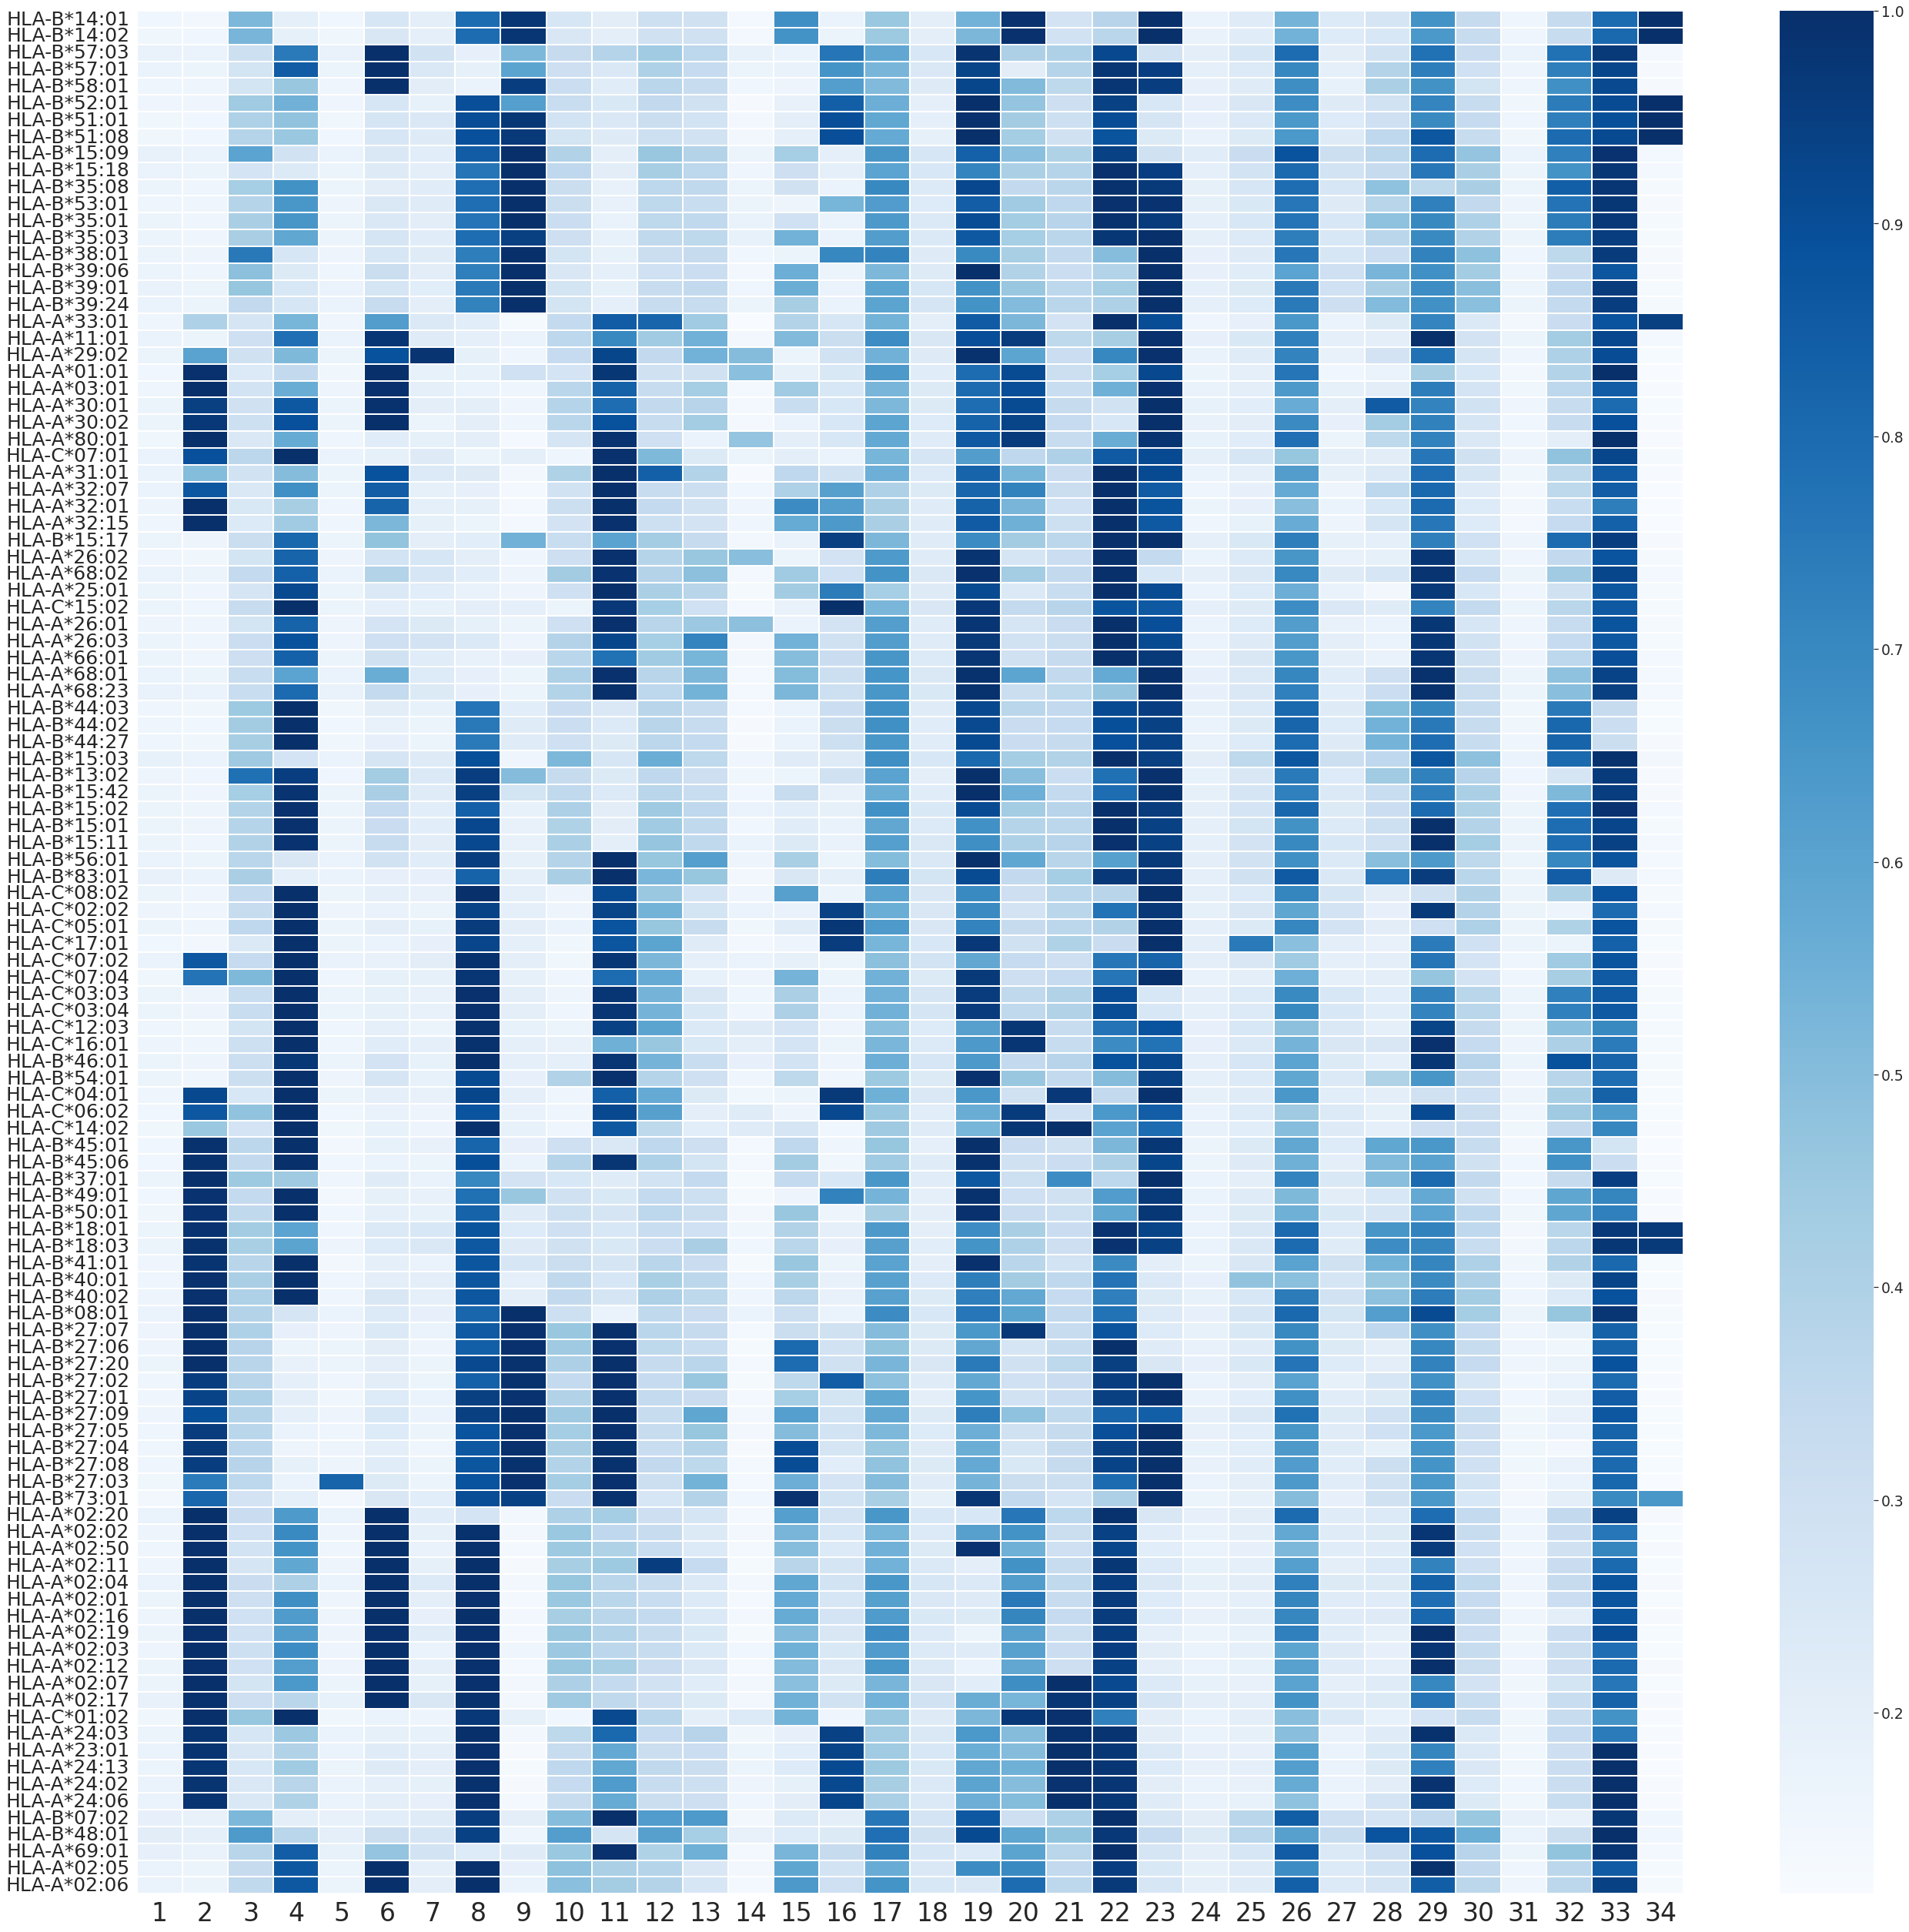

In [28]:
fig, ax = plt.subplots(figsize=(45,45)) 
sn.set(font_scale=1.7)

ax = sn.heatmap(pos_imp_hla, annot=False, cmap='Blues', linewidths=0.1, xticklabels=True, yticklabels=True)

ax.set_xticklabels([int(x+1) for x in ax.get_xticks()], size=33)
ax.set_yticklabels(list(pos_imp_hla.index), size=25)


In [13]:
from Levenshtein import distance as levenshtein_distance
import statistics

df_all = []

for i in range(5):
    df_all.append(pd.read_csv(data_dir + 'upd_{}_d.csv'.format(i), index_col = 0) ) #.drop_duplicates())
    
df_concat = pd.concat(df_all)

df_HLA = df_concat[['HLA', 'HLA_sequence']].drop_duplicates()
df_HLA

HLA                        HLA_sequence
4      HLA-B*15:01  YYAMYREISTNTYESNLYLRYDSYTWAEWAYLWY
6      HLA-C*07:01  YDSGYRENYRQADVSNLYLRYDSYTLAALAYTWY
17     HLA-B*58:01  YYATYGENMASTYENIAYIRYDSYTWAVLAYLWY
19     HLA-C*04:01  YSAGYREKYRQADVNKLYLRFNFYTWAERAYTWY
26     HLA-B*07:02  YYSEYRNIYAQTDESNLYLSYDYYTWAERAYEWY
...            ...                                 ...
40358  HLA-A*80:01  YFAMYEENVAHTNANTLYIIYRDYTWARLAYEGY
41666  HLA-B*27:20  YHTEYREICAKTDESTLYLNYNYYTWAELAYEWY
44623  HLA-A*26:03  YYAMYRNNVAHTHVDTLYIRYQDYTWAEWAYRWY
64532  HLA-B*15:09  YYSEYRNICTNTYESNLYLRYNYYTWAELAYLWY
73318  HLA-B*44:27  YYTKYREISTNTYENTAYIRYDDYTWAVDAYLSY

[112 rows x 2 columns]

In [30]:
HLA_text_sim_dict = dict()


for HLA_1 in df_HLA.HLA:
    print(HLA_1, end=', ')
    hla_seq_1 = list(df_HLA[df_HLA['HLA']== HLA_1].HLA_sequence)[0]
    ll = []
    for HLA_2 in df_HLA.HLA:
        hla_seq_2 = list(df_HLA[df_HLA['HLA']== HLA_2].HLA_sequence)[0]
        d = levenshtein_distance(hla_seq_1, hla_seq_2)
        ll.append(d)
    HLA_text_sim_dict[HLA_1] = ll



HLA-B*15:01, HLA-C*07:01, HLA-B*58:01, HLA-C*04:01, HLA-B*07:02, HLA-A*02:03, HLA-A*23:01, HLA-A*31:01, HLA-A*11:01, HLA-B*27:05, HLA-B*45:01, HLA-A*32:01, HLA-A*03:01, HLA-A*68:01, HLA-A*02:01, HLA-B*13:02, HLA-B*57:01, HLA-A*24:02, HLA-B*08:01, HLA-C*05:01, HLA-B*37:01, HLA-A*02:04, HLA-A*01:01, HLA-C*01:02, HLA-B*40:02, HLA-B*35:01, HLA-A*24:06, HLA-B*18:01, HLA-B*40:01, HLA-C*06:02, HLA-B*35:03, HLA-A*30:01, HLA-A*33:01, HLA-C*15:02, HLA-C*03:04, HLA-B*56:01, HLA-A*02:05, HLA-B*39:01, HLA-B*51:01, HLA-B*27:06, HLA-C*02:02, HLA-C*07:04, HLA-B*44:02, HLA-C*14:02, HLA-B*27:09, HLA-C*08:02, HLA-C*17:01, HLA-A*68:02, HLA-B*50:01, HLA-C*07:02, HLA-B*49:01, HLA-B*57:03, HLA-A*02:07, HLA-B*44:03, HLA-C*03:03, HLA-B*27:02, HLA-B*15:18, HLA-B*35:08, HLA-A*02:02, HLA-A*69:01, HLA-B*52:01, HLA-A*02:06, HLA-B*83:01, HLA-B*27:03, HLA-A*02:20, HLA-C*16:01, HLA-B*38:01, HLA-B*53:01, HLA-B*27:01, HLA-B*14:02, HLA-B*46:01, HLA-B*15:17, HLA-B*39:06, HLA-C*12:03, HLA-A*29:02, HLA-B*51:08, HLA-B*73:01,

In [218]:
tbl_cluster_sim = tbl_cluster_sim.reindex(index_order)
tbl_cluster_sim = tbl_cluster_sim[index_order]
tbl_cluster_sim

HLA-B*14:02  HLA-B*14:01  HLA-B*57:03  HLA-B*58:01  HLA-B*57:01  \
HLA-B*14:02     1.000000     0.999651     0.120239     0.412257     0.236667   
HLA-B*14:01     0.999651     1.000000     0.127575     0.418289     0.243584   
HLA-B*57:03     0.120239     0.127575     1.000000     0.843115     0.897185   
HLA-B*58:01     0.412257     0.418289     0.843115     1.000000     0.932691   
HLA-B*57:01     0.236667     0.243584     0.897185     0.932691     1.000000   
...                  ...          ...          ...          ...          ...   
HLA-B*07:02     0.183643     0.187010     0.407824     0.292708     0.303964   
HLA-B*48:01     0.281444     0.290010     0.483963     0.415015     0.426904   
HLA-A*69:01     0.134422     0.139313     0.627262     0.428244     0.514081   
HLA-A*02:06     0.305334     0.309954     0.602447     0.457686     0.517142   
HLA-A*02:05     0.301168     0.310655     0.688554     0.531815     0.602927   

             HLA-B*52:01  HLA-B*51:01  HLA-B*51:08  HLA-B*15:09  HLA-B*15:18  \
HLA-B*14:02     0.527658     0.573874     0.564944     0.525019     0.616203   
HLA-B*14:01     0.531852     0.577453     0.569406     0.528072     0.619367   
HLA-B*57:03     0.626727     0.597414     0.608625     0.594374     0.546706   
HLA-B*58:01     0.541367     0.576320     0.576342     0.622610     0.757353   
HLA-B*57:01     0.540897     0.525799     0.530121     0.530964     0.664184   
...                  ...          ...          ...          ...          ...   
HLA-B*07:02     0.474702     0.408267     0.380508     0.620947     0.538681   
HLA-B*48:01     0.551089     0.466173     0.482085     0.712456     0.608142   
HLA-A*69:01     0.356766     0.280345     0.295210     0.477377     0.425922   
HLA-A*02:06     0.447590     0.367074     0.371359     0.547002     0.467849   
HLA-A*02:05     0.534660     0.452739     0.464870     0.595700     0.504484   

             ...  HLA-A*24:03  HLA-A*23:01  HLA-A*24:13  HLA-A*24:02  \
HLA-B*14:02  ...     0.064249     0.106609     0.115159     0.119189   
HLA-B*14:01  ...     0.066968     0.105608     0.114643     0.120197   
HLA-B*57:03  ...     0.421347     0.438045     0.451098     0.453970   
HLA-B*58:01  ...     0.256664     0.297651     0.302534     0.301626   
HLA-B*57:01  ...     0.307073     0.336266     0.343137     0.342593   
...          ...          ...          ...          ...          ...   
HLA-B*07:02  ...     0.524709     0.545144     0.552970     0.531256   
HLA-B*48:01  ...     0.491507     0.521326     0.532565     0.537286   
HLA-A*69:01  ...     0.476302     0.451976     0.472286     0.480542   
HLA-A*02:06  ...     0.470619     0.507780     0.528422     0.511962   
HLA-A*02:05  ...     0.520207     0.518354     0.541784     0.545362   

             HLA-A*24:06  HLA-B*07:02  HLA-B*48:01  HLA-A*69:01  HLA-A*02:06  \
HLA-B*14:02     0.117454     0.183643     0.281444     0.134422     0.305334   
HLA-B*14:01     0.118342     0.187010     0.290010     0.139313     0.309954   
HLA-B*57:03     0.437239     0.407824     0.483963     0.627262     0.602447   
HLA-B*58:01     0.295500     0.292708     0.415015     0.428244     0.457686   
HLA-B*57:01     0.336483     0.303964     0.426904     0.514081     0.517142   
...                  ...          ...          ...          ...          ...   
HLA-B*07:02     0.499540     1.000000     0.723259     0.595662     0.508628   
HLA-B*48:01     0.537232     0.723259     1.000000     0.495674     0.605274   
HLA-A*69:01     0.457798     0.595662     0.495674     1.000000     0.745259   
HLA-A*02:06     0.506115     0.508628     0.605274     0.745259     1.000000   
HLA-A*02:05     0.536523     0.531494     0.678705     0.686281     0.951723   

             HLA-A*02:05  
HLA-B*14:02     0.301168  
HLA-B*14:01     0.310655  
HLA-B*57:03     0.688554  
HLA-B*58:01     0.531815  
HLA-B*57:01     0.602927  
...                  ...  
HLA-B*07:02     0.531494  
HLA-B*48:01     0.678705  
HLA-A*69:01     0.6862

<AxesSubplot:>

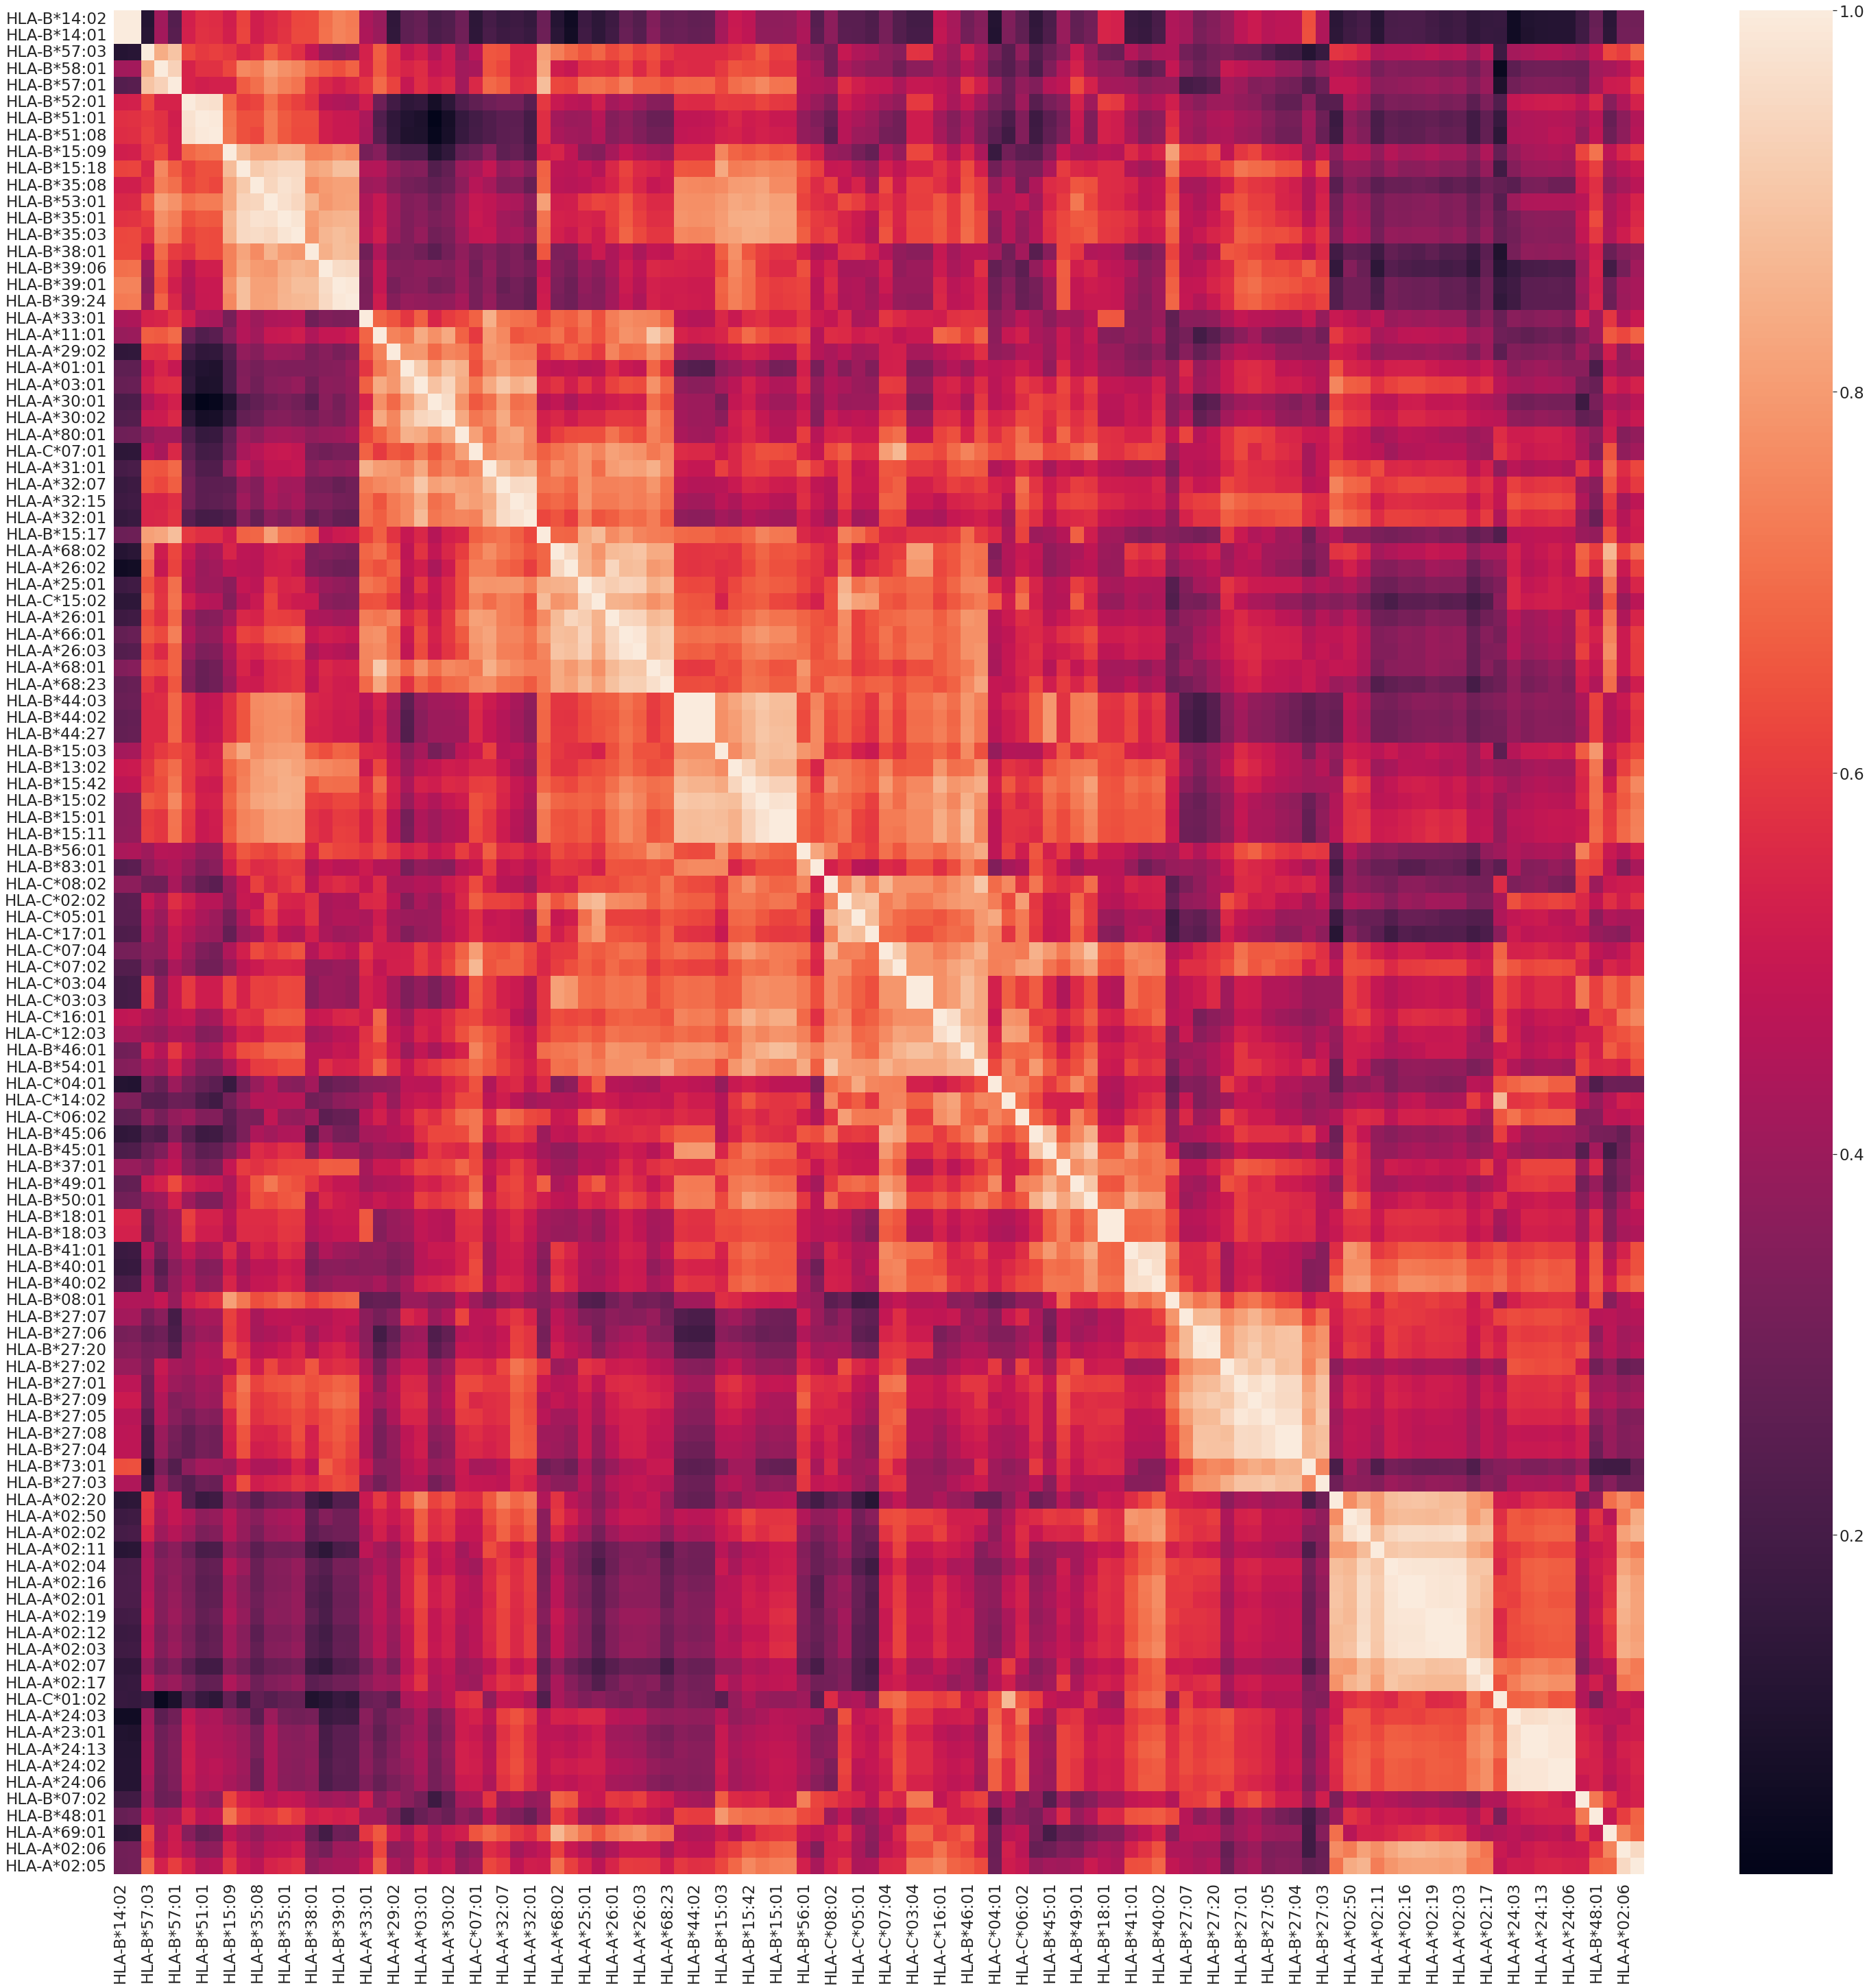

In [219]:
fig, ax = plt.subplots(figsize=(50,50)) 
sns.heatmap(tbl_cluster_sim, annot=False)

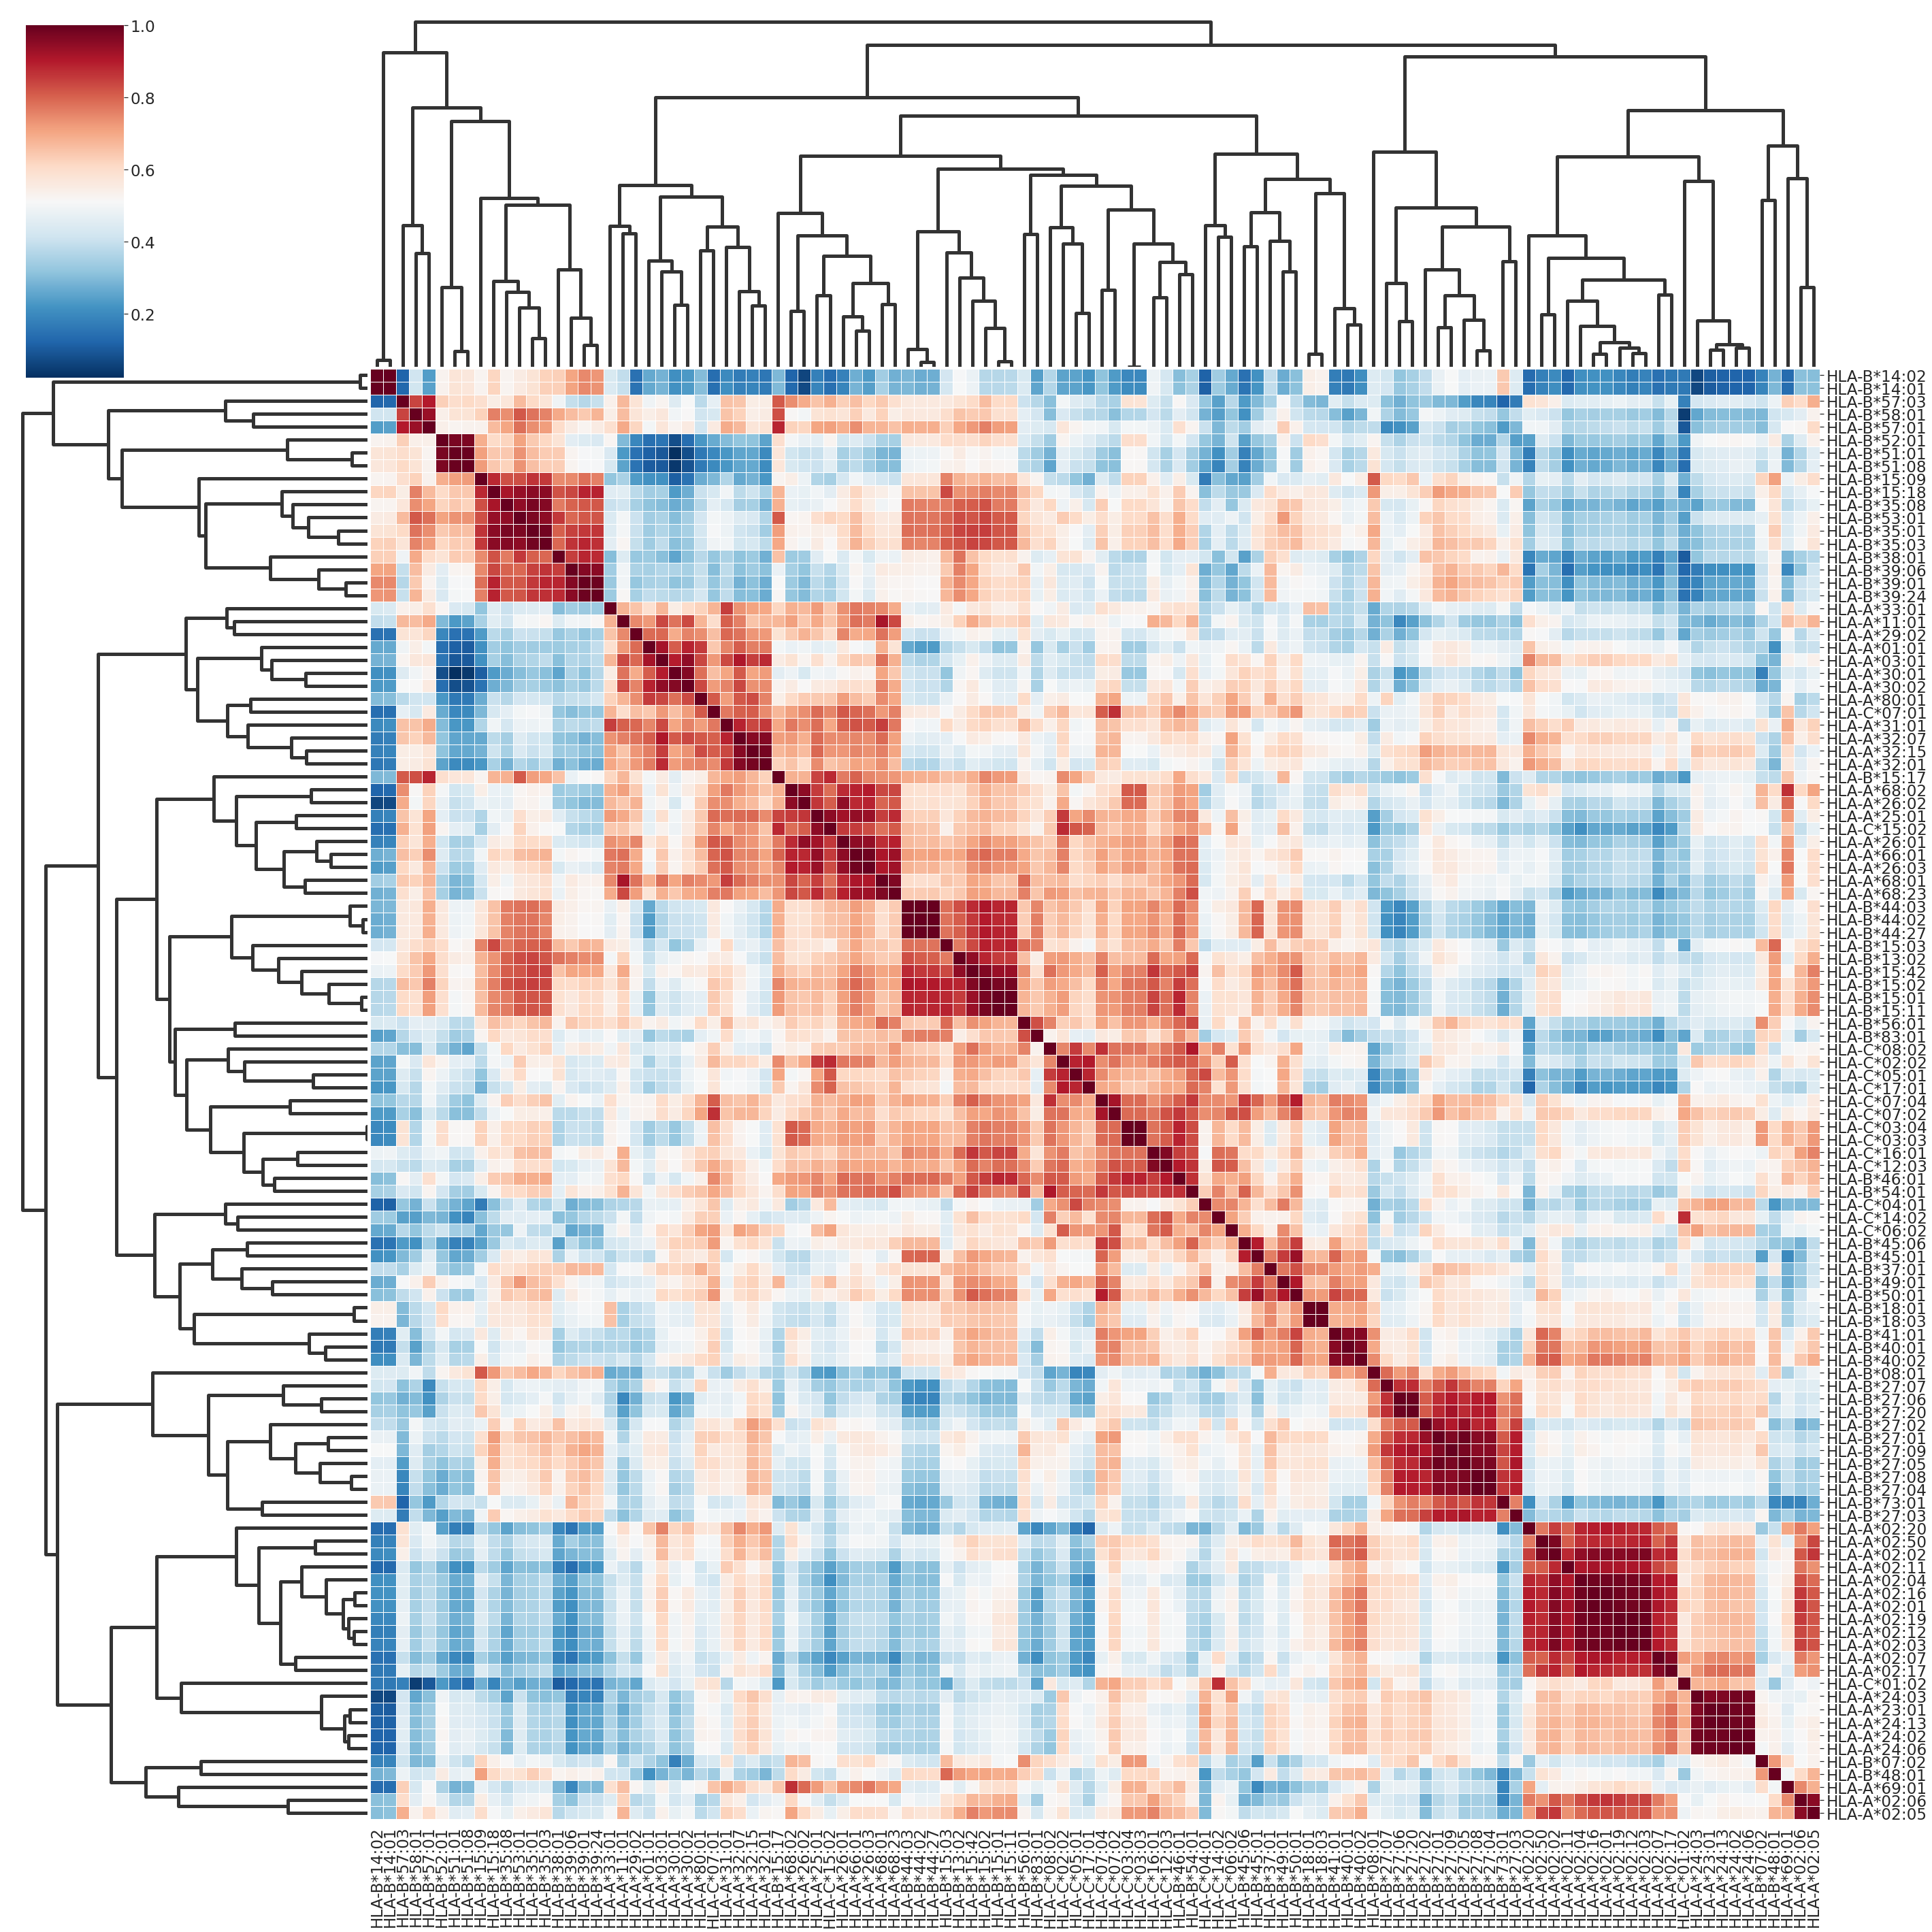

In [220]:
sn.set(font_scale=2.1)
g = sn.clustermap(tbl_cluster_sim, cmap='RdBu_r', linewidths=0.5, figsize=(40, 40), xticklabels=True, yticklabels=True, annot_kws={"size": 36})
for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(5)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(5)

In [222]:
tbl_text_sim = pd.DataFrame(HLA_text_sim_dict)
tbl_text_sim.index = tbl_text_sim.columns
tbl_text_sim = tbl_text_sim.reindex(index_order)
tbl_text_sim = tbl_text_sim[index_order]
tbl_text_sim

HLA-B*14:02  HLA-B*14:01  HLA-B*57:03  HLA-B*58:01  HLA-B*57:01  \
HLA-B*14:02            0            0           18           19           19   
HLA-B*14:01            0            0           18           19           19   
HLA-B*57:03           18           18            0            4            2   
HLA-B*58:01           19           19            4            0            2   
HLA-B*57:01           19           19            2            2            0   
...                  ...          ...          ...          ...          ...   
HLA-B*07:02            9            9           17           17           17   
HLA-B*48:01           10           10           15           17           17   
HLA-A*69:01           15           15           13           14           14   
HLA-A*02:06           18           18           12           13           13   
HLA-A*02:05           18           18           13           14           14   

             HLA-B*52:01  HLA-B*51:01  HLA-B*51:08  HLA-B*15:09  HLA-B*15:18  \
HLA-B*14:02           12           11           13            5            6   
HLA-B*14:01           12           11           13            5            6   
HLA-B*57:03           10           11           11           14           16   
HLA-B*58:01           11           12           12           15           13   
HLA-B*57:01           12           13           13           16           14   
...                  ...          ...          ...          ...          ...   
HLA-B*07:02           16           15           16            8            8   
HLA-B*48:01           12           14           14            7            9   
HLA-A*69:01           17           16           16           14           15   
HLA-A*02:06           17           18           18           16           17   
HLA-A*02:05           18           19           18           16           17   

             ...  HLA-A*24:03  HLA-A*23:01  HLA-A*24:13  HLA-A*24:02  \
HLA-B*14:02  ...           19           19           19           20   
HLA-B*14:01  ...           19           19           19           20   
HLA-B*57:03  ...           12           12           12           13   
HLA-B*58:01  ...           14           14           14           15   
HLA-B*57:01  ...           13           13           13           14   
...          ...          ...          ...          ...          ...   
HLA-B*07:02  ...           17           18           18           18   
HLA-B*48:01  ...           19           19           19           20   
HLA-A*69:01  ...           13           13           13           14   
HLA-A*02:06  ...           11           11           11           12   
HLA-A*02:05  ...           10           11           11           11   

             HLA-A*24:06  HLA-B*07:02  HLA-B*48:01  HLA-A*69:01  HLA-A*02:06  \
HLA-B*14:02           20            9           10           15           18   
HLA-B*14:01           20            9           10           15           18   
HLA-B*57:03           13           17           15           13           12   
HLA-B*58:01           15           17           17           14           13   
HLA-B*57:01           14           17           17           14           13   
...                  ...          ...          ...          ...          ...   
HLA-B*07:02           18            0           10           13           17   
HLA-B*48:01           20           10            0           17           17   
HLA-A*69:01           14           13           17            0            5   
HLA-A*02:06           12           17           17            5            0   
HLA-A*02:05           10           16           17            7            2   

             HLA-A*02:05  
HLA-B*14:02           18  
HLA-B*14:01           18  
HLA-B*57:03           13  
HLA-B*58:01           14  
HLA-B*57:01           14  
...                  ...  
HLA-B*07:02           16  
HLA-B*48:01           17  
HLA-A*69:01           

<AxesSubplot:>

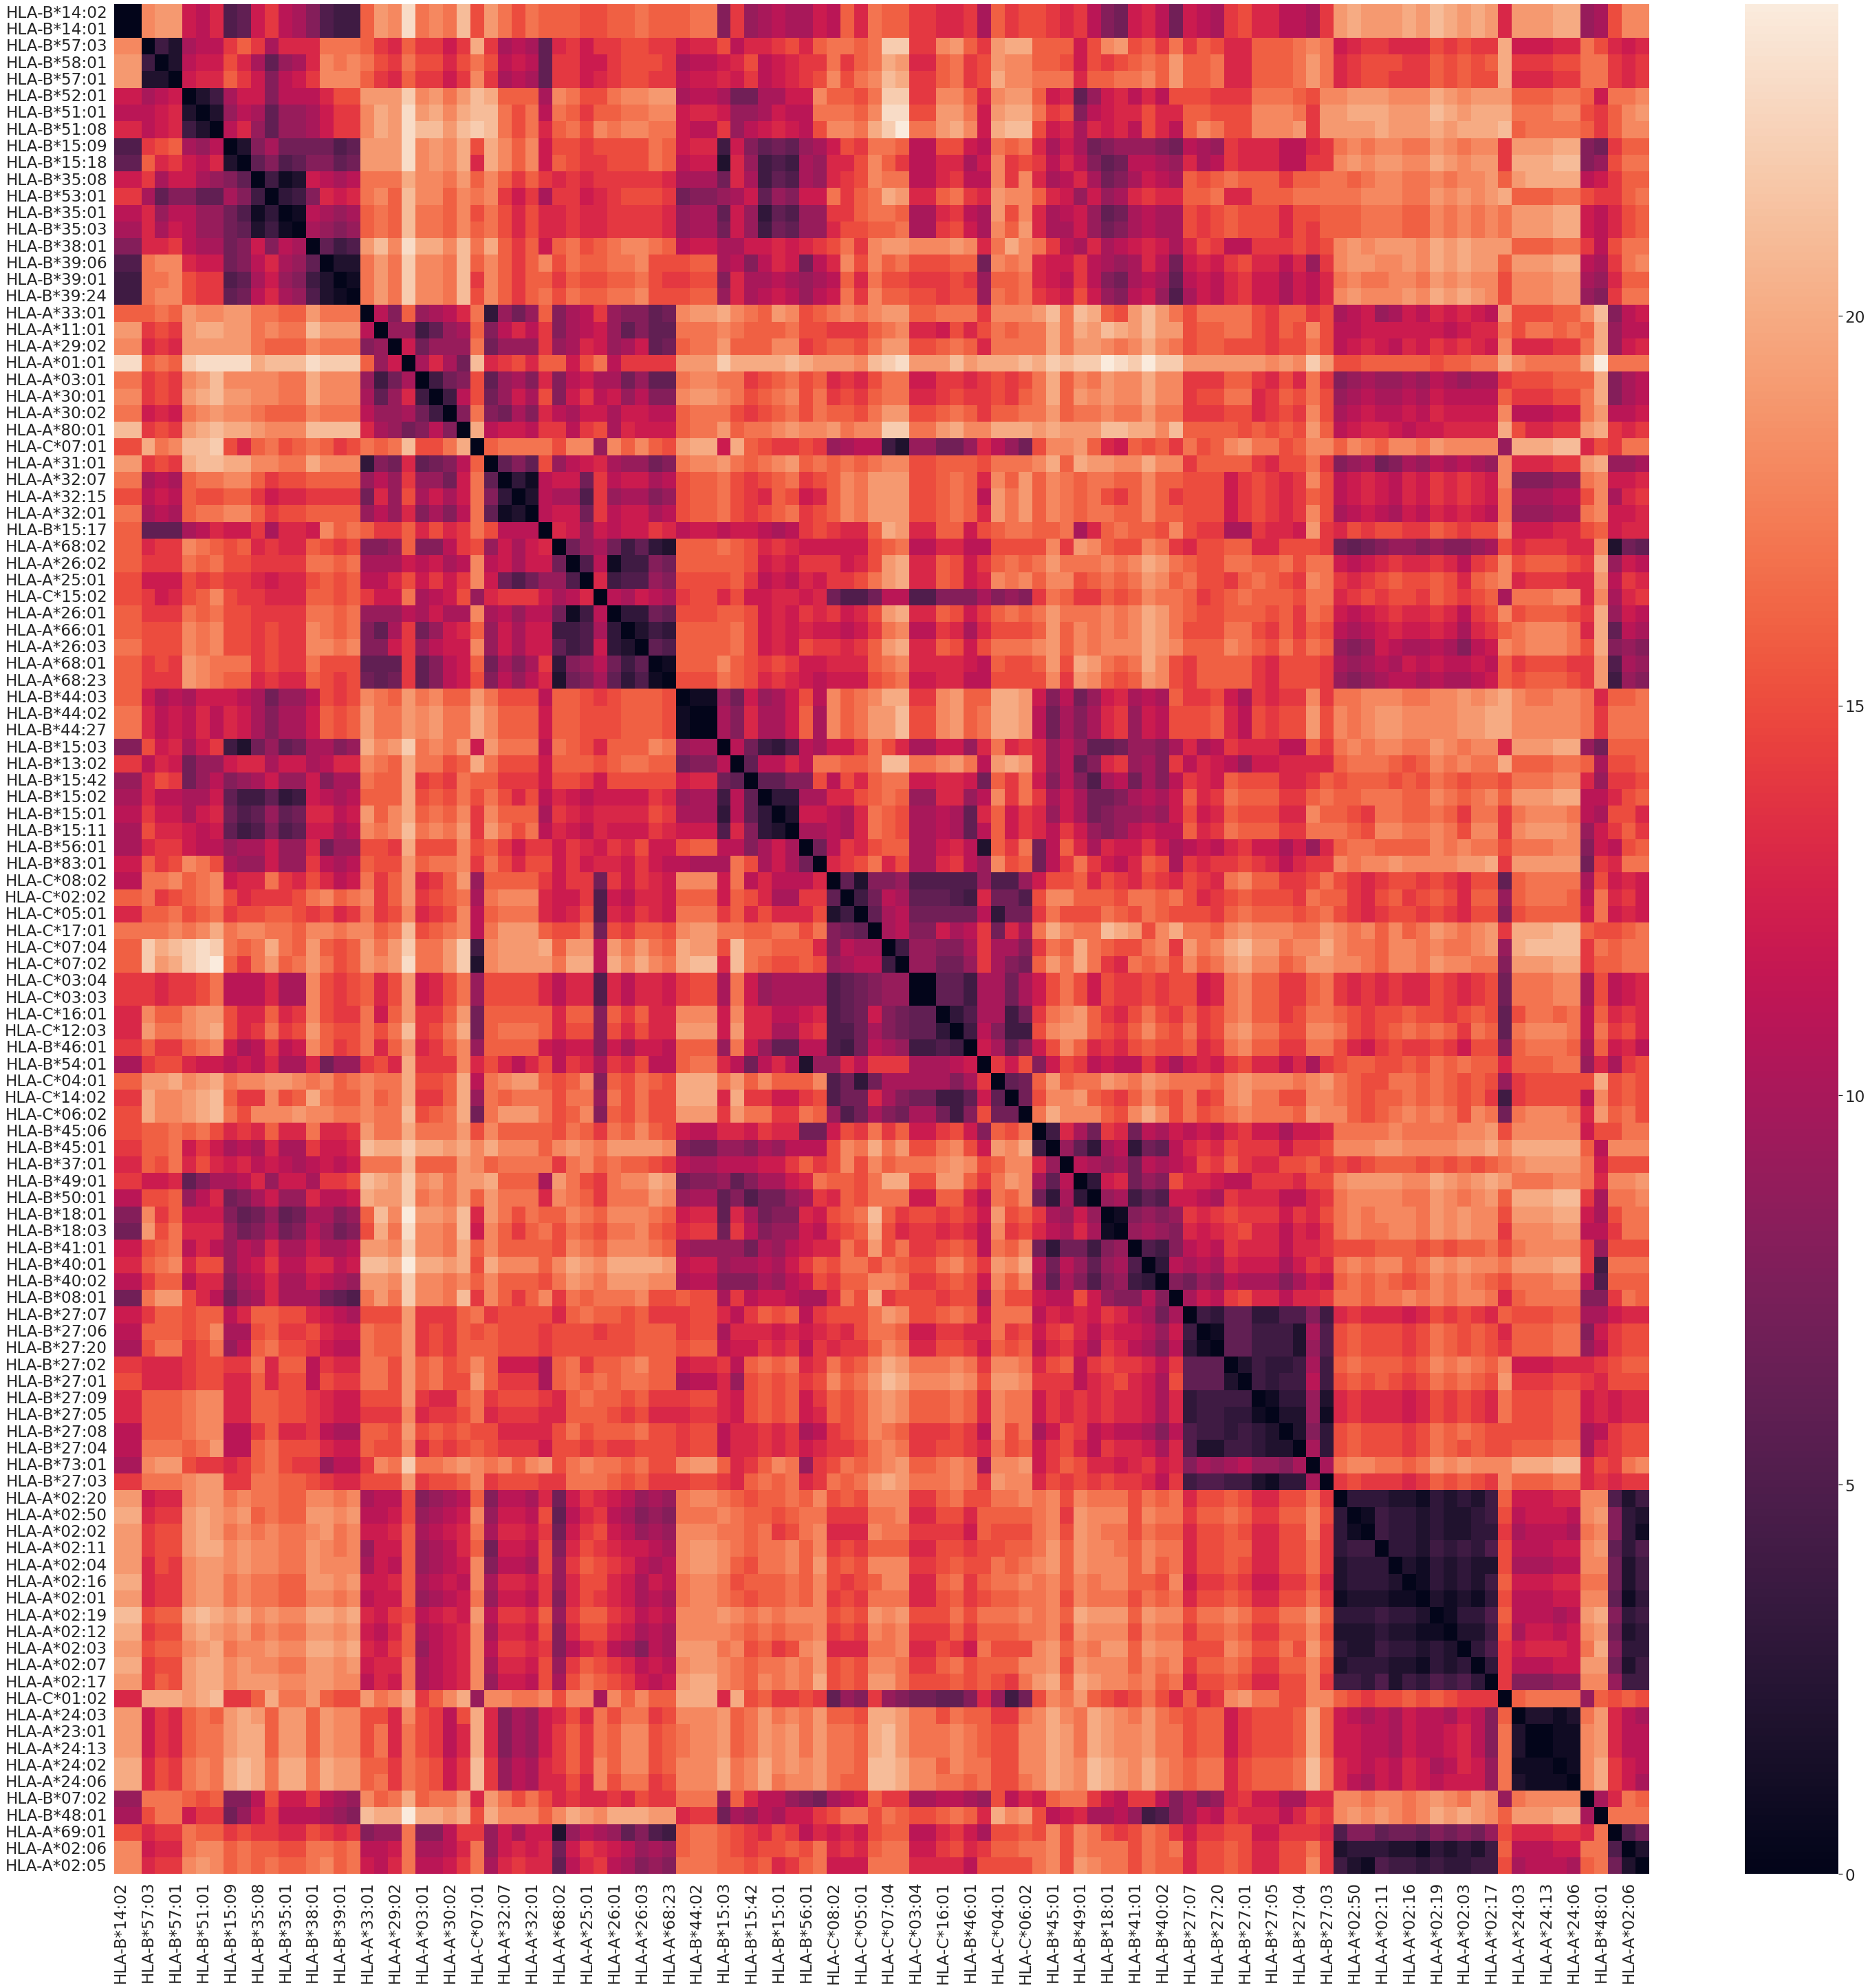

In [223]:
fig, ax = plt.subplots(figsize=(50,50)) 
sns.heatmap(tbl_text_sim, annot=False)

In [205]:
tbl_text_sim = pd.DataFrame(HLA_text_sim_dict)
tbl_text_sim.index = tbl_text_sim.columns
tbl_text_sim = tbl_text_sim.reindex(index_order)
tbl_text_sim = tbl_text_sim[index_order]
tbl_text_sim

HLA-B*15:17  HLA-B*57:03  HLA-B*58:01  HLA-B*57:01  HLA-A*02:16  \
HLA-B*15:17            0            6            6            6           14   
HLA-B*57:03            6            0            4            2           13   
HLA-B*58:01            6            4            0            2           14   
HLA-B*57:01            6            2            2            0           14   
HLA-A*02:16           14           13           14           14            0   
...                  ...          ...          ...          ...          ...   
HLA-B*14:02           16           18           19           19           20   
HLA-B*14:01           16           18           19           19           20   
HLA-B*39:06           18           17           18           18           19   
HLA-B*39:01           16           17           17           18           18   
HLA-B*39:24           17           17           18           18           19   

             HLA-A*02:06  HLA-A*02:01  HLA-A*02:20  HLA-A*02:11  HLA-A*02:04  \
HLA-B*15:17           13           14           13           15           15   
HLA-B*57:03           12           13           12           14           13   
HLA-B*58:01           13           14           13           15           15   
HLA-B*57:01           13           14           13           15           14   
HLA-A*02:16            2            1            2            3            2   
...                  ...          ...          ...          ...          ...   
HLA-B*14:02           18           19           19           19           19   
HLA-B*14:01           18           19           19           19           19   
HLA-B*39:06           17           18           18           18           18   
HLA-B*39:01           16           17           17           17           18   
HLA-B*39:24           17           18           18           18           18   

             ...  HLA-B*15:09  HLA-B*15:18  HLA-B*15:03  HLA-B*38:01  \
HLA-B*15:17  ...           12           12           11           12   
HLA-B*57:03  ...           14           16           15           13   
HLA-B*58:01  ...           15           13           12           13   
HLA-B*57:01  ...           16           14           13           14   
HLA-A*02:16  ...           17           18           17           19   
...          ...          ...          ...          ...          ...   
HLA-B*14:02  ...            5            6            8            8   
HLA-B*14:01  ...            5            6            8            8   
HLA-B*39:06  ...            7            8           10            6   
HLA-B*39:01  ...            5            6            8            4   
HLA-B*39:24  ...            6            7            9            5   

             HLA-B*08:01  HLA-B*14:02  HLA-B*14:01  HLA-B*39:06  HLA-B*39:01  \
HLA-B*15:17           18           16           16           18           16   
HLA-B*57:03           17           18           18           17           17   
HLA-B*58:01           19           19           19           18           17   
HLA-B*57:01           19           19           19           18           18   
HLA-A*02:16           18           20           20           19           18   
...                  ...          ...          ...          ...          ...   
HLA-B*14:02            7            0            0            5            4   
HLA-B*14:01            7            0            0            5            4   
HLA-B*39:06            7            5            5            0            2   
HLA-B*39:01            6            4            4            2            0   
HLA-B*39:24            5            4            4            2            1   

             HLA-B*39:24  
HLA-B*15:17           17  
HLA-B*57:03           17  
HLA-B*58:01           18  
HLA-B*57:01           18  
HLA-A*02:16           19  
...                  ...  
HLA-B*14:02            4  
HLA-B*14:01            4  
HLA-B*39:06           

<AxesSubplot:>

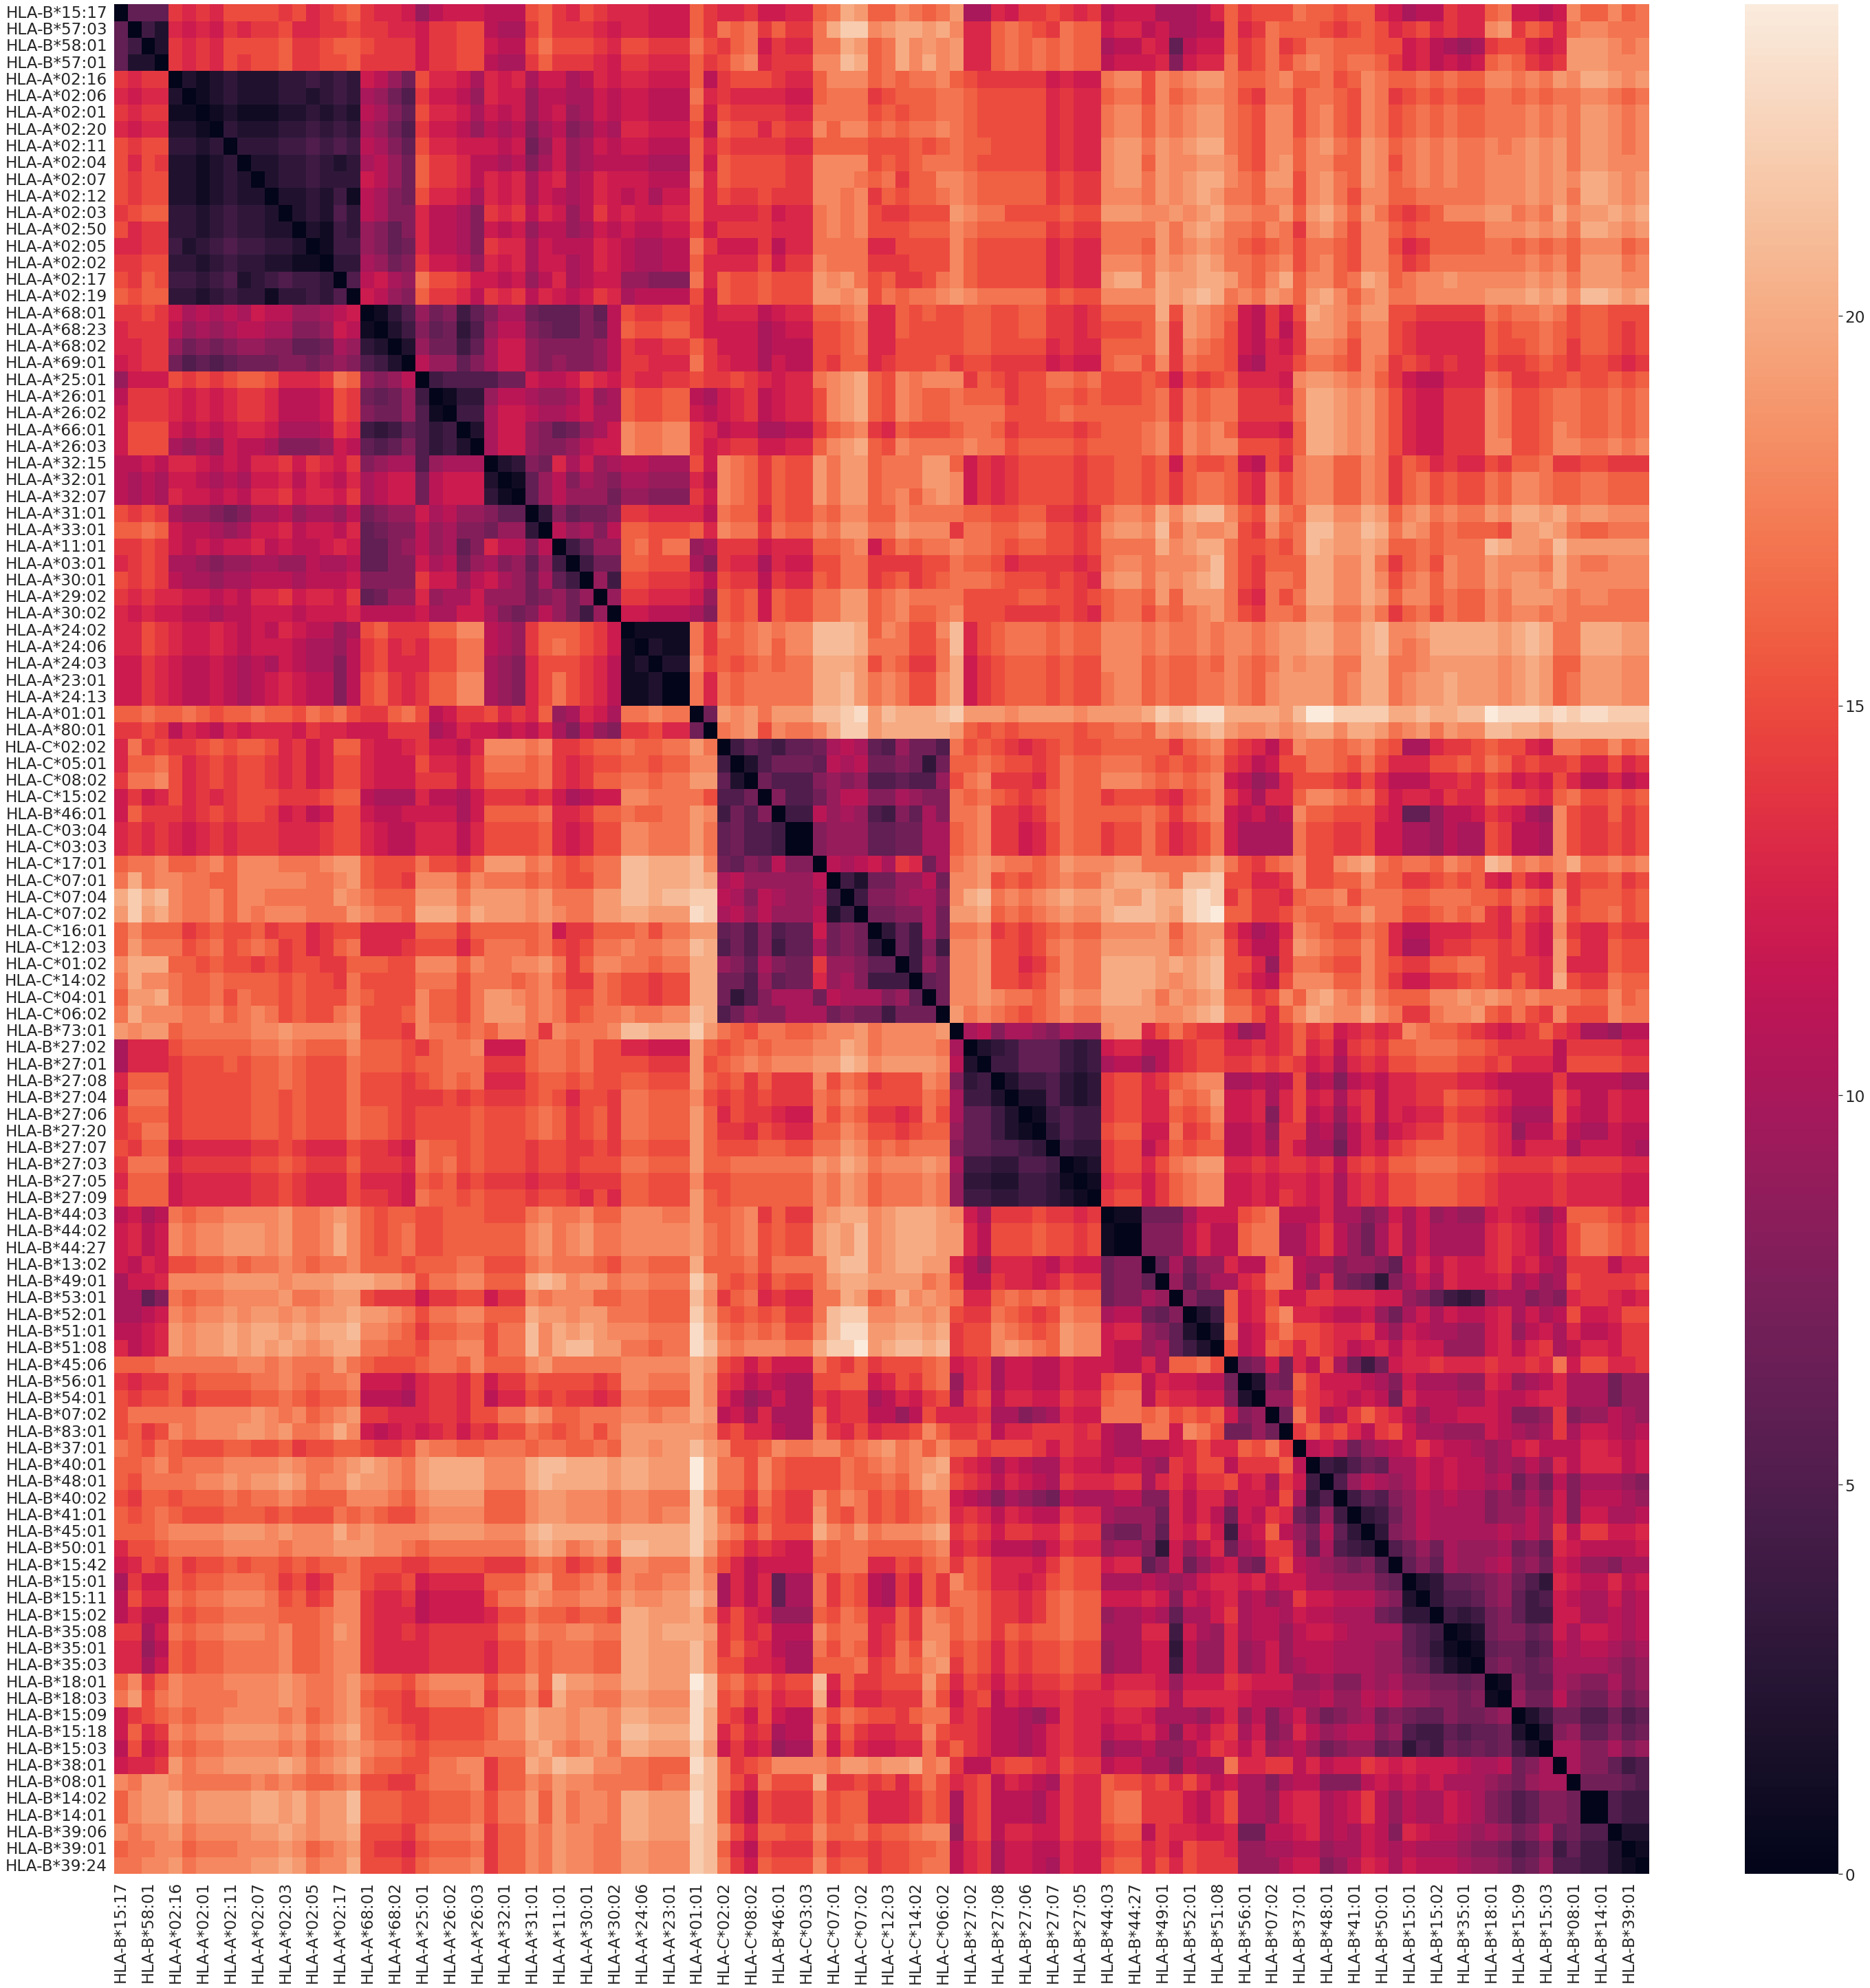

In [207]:
fig, ax = plt.subplots(figsize=(50,50)) 
sns.heatmap(tbl_text_sim, annot=False)

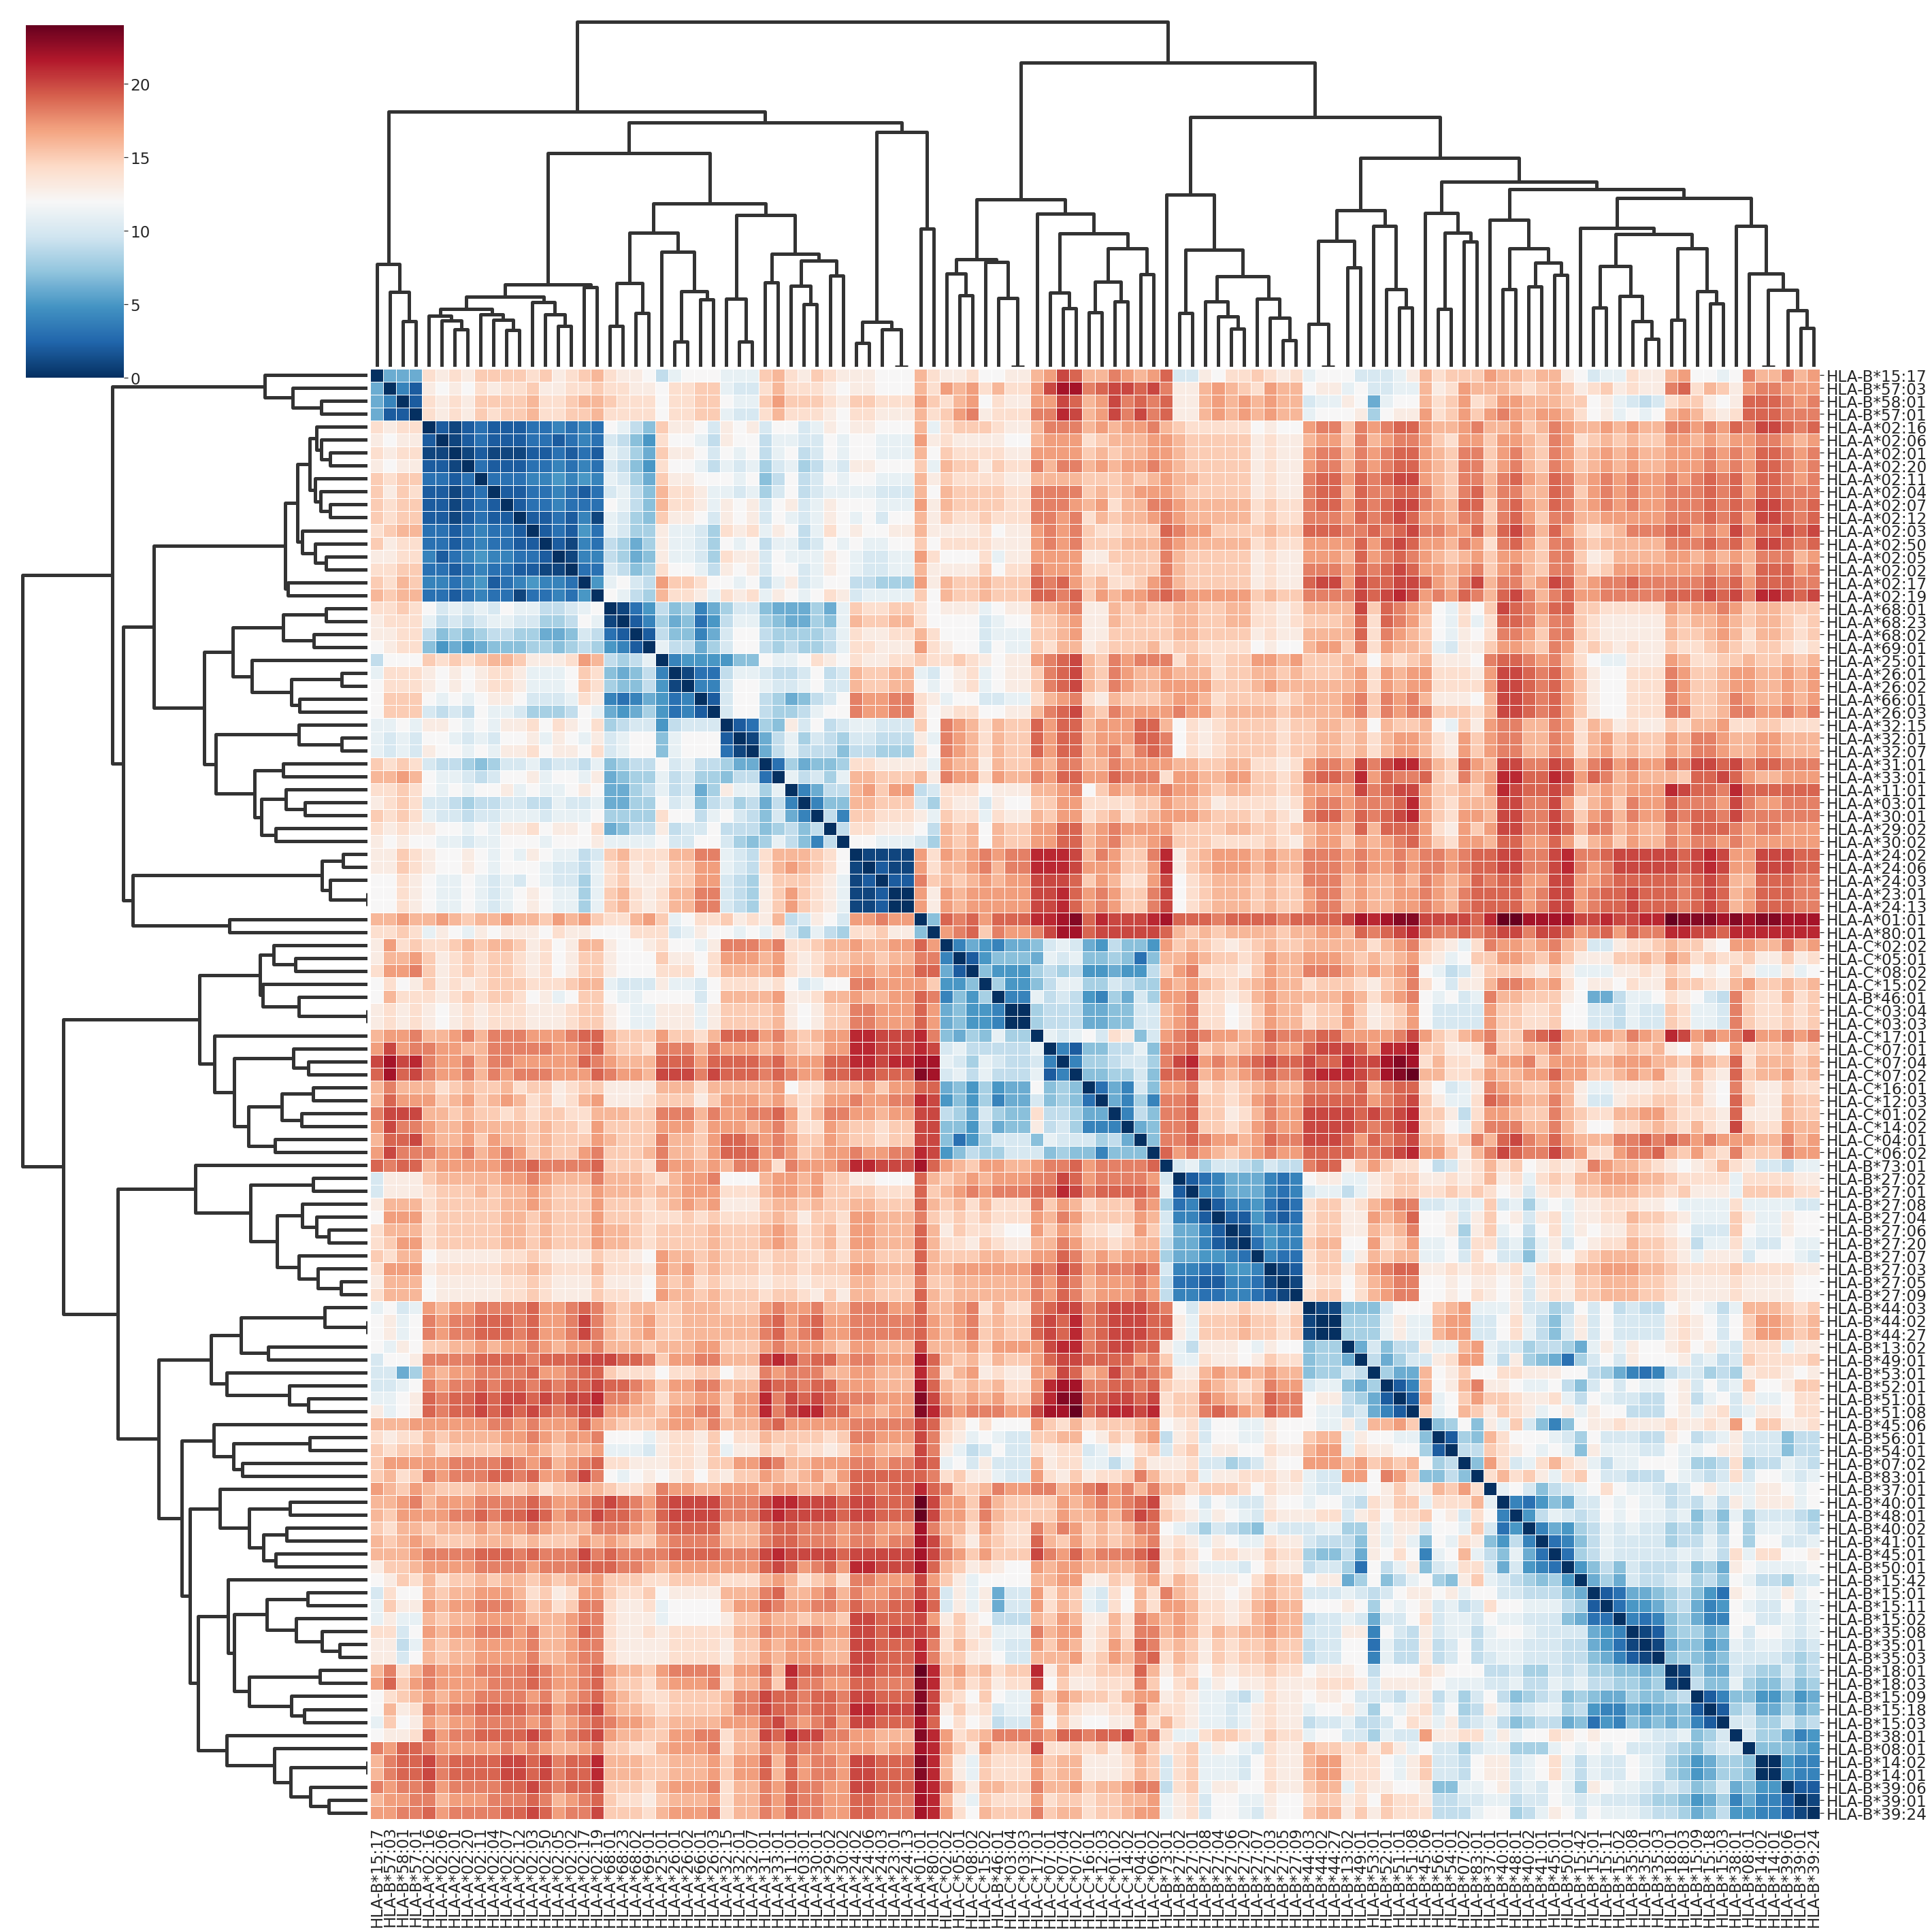

In [208]:
sn.set(font_scale=2.1)
g = sn.clustermap(tbl_text_sim, cmap='RdBu_r', linewidths=0.5, figsize=(40, 40), xticklabels=True, yticklabels=True, annot_kws={"size": 36})
for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(5)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(5)

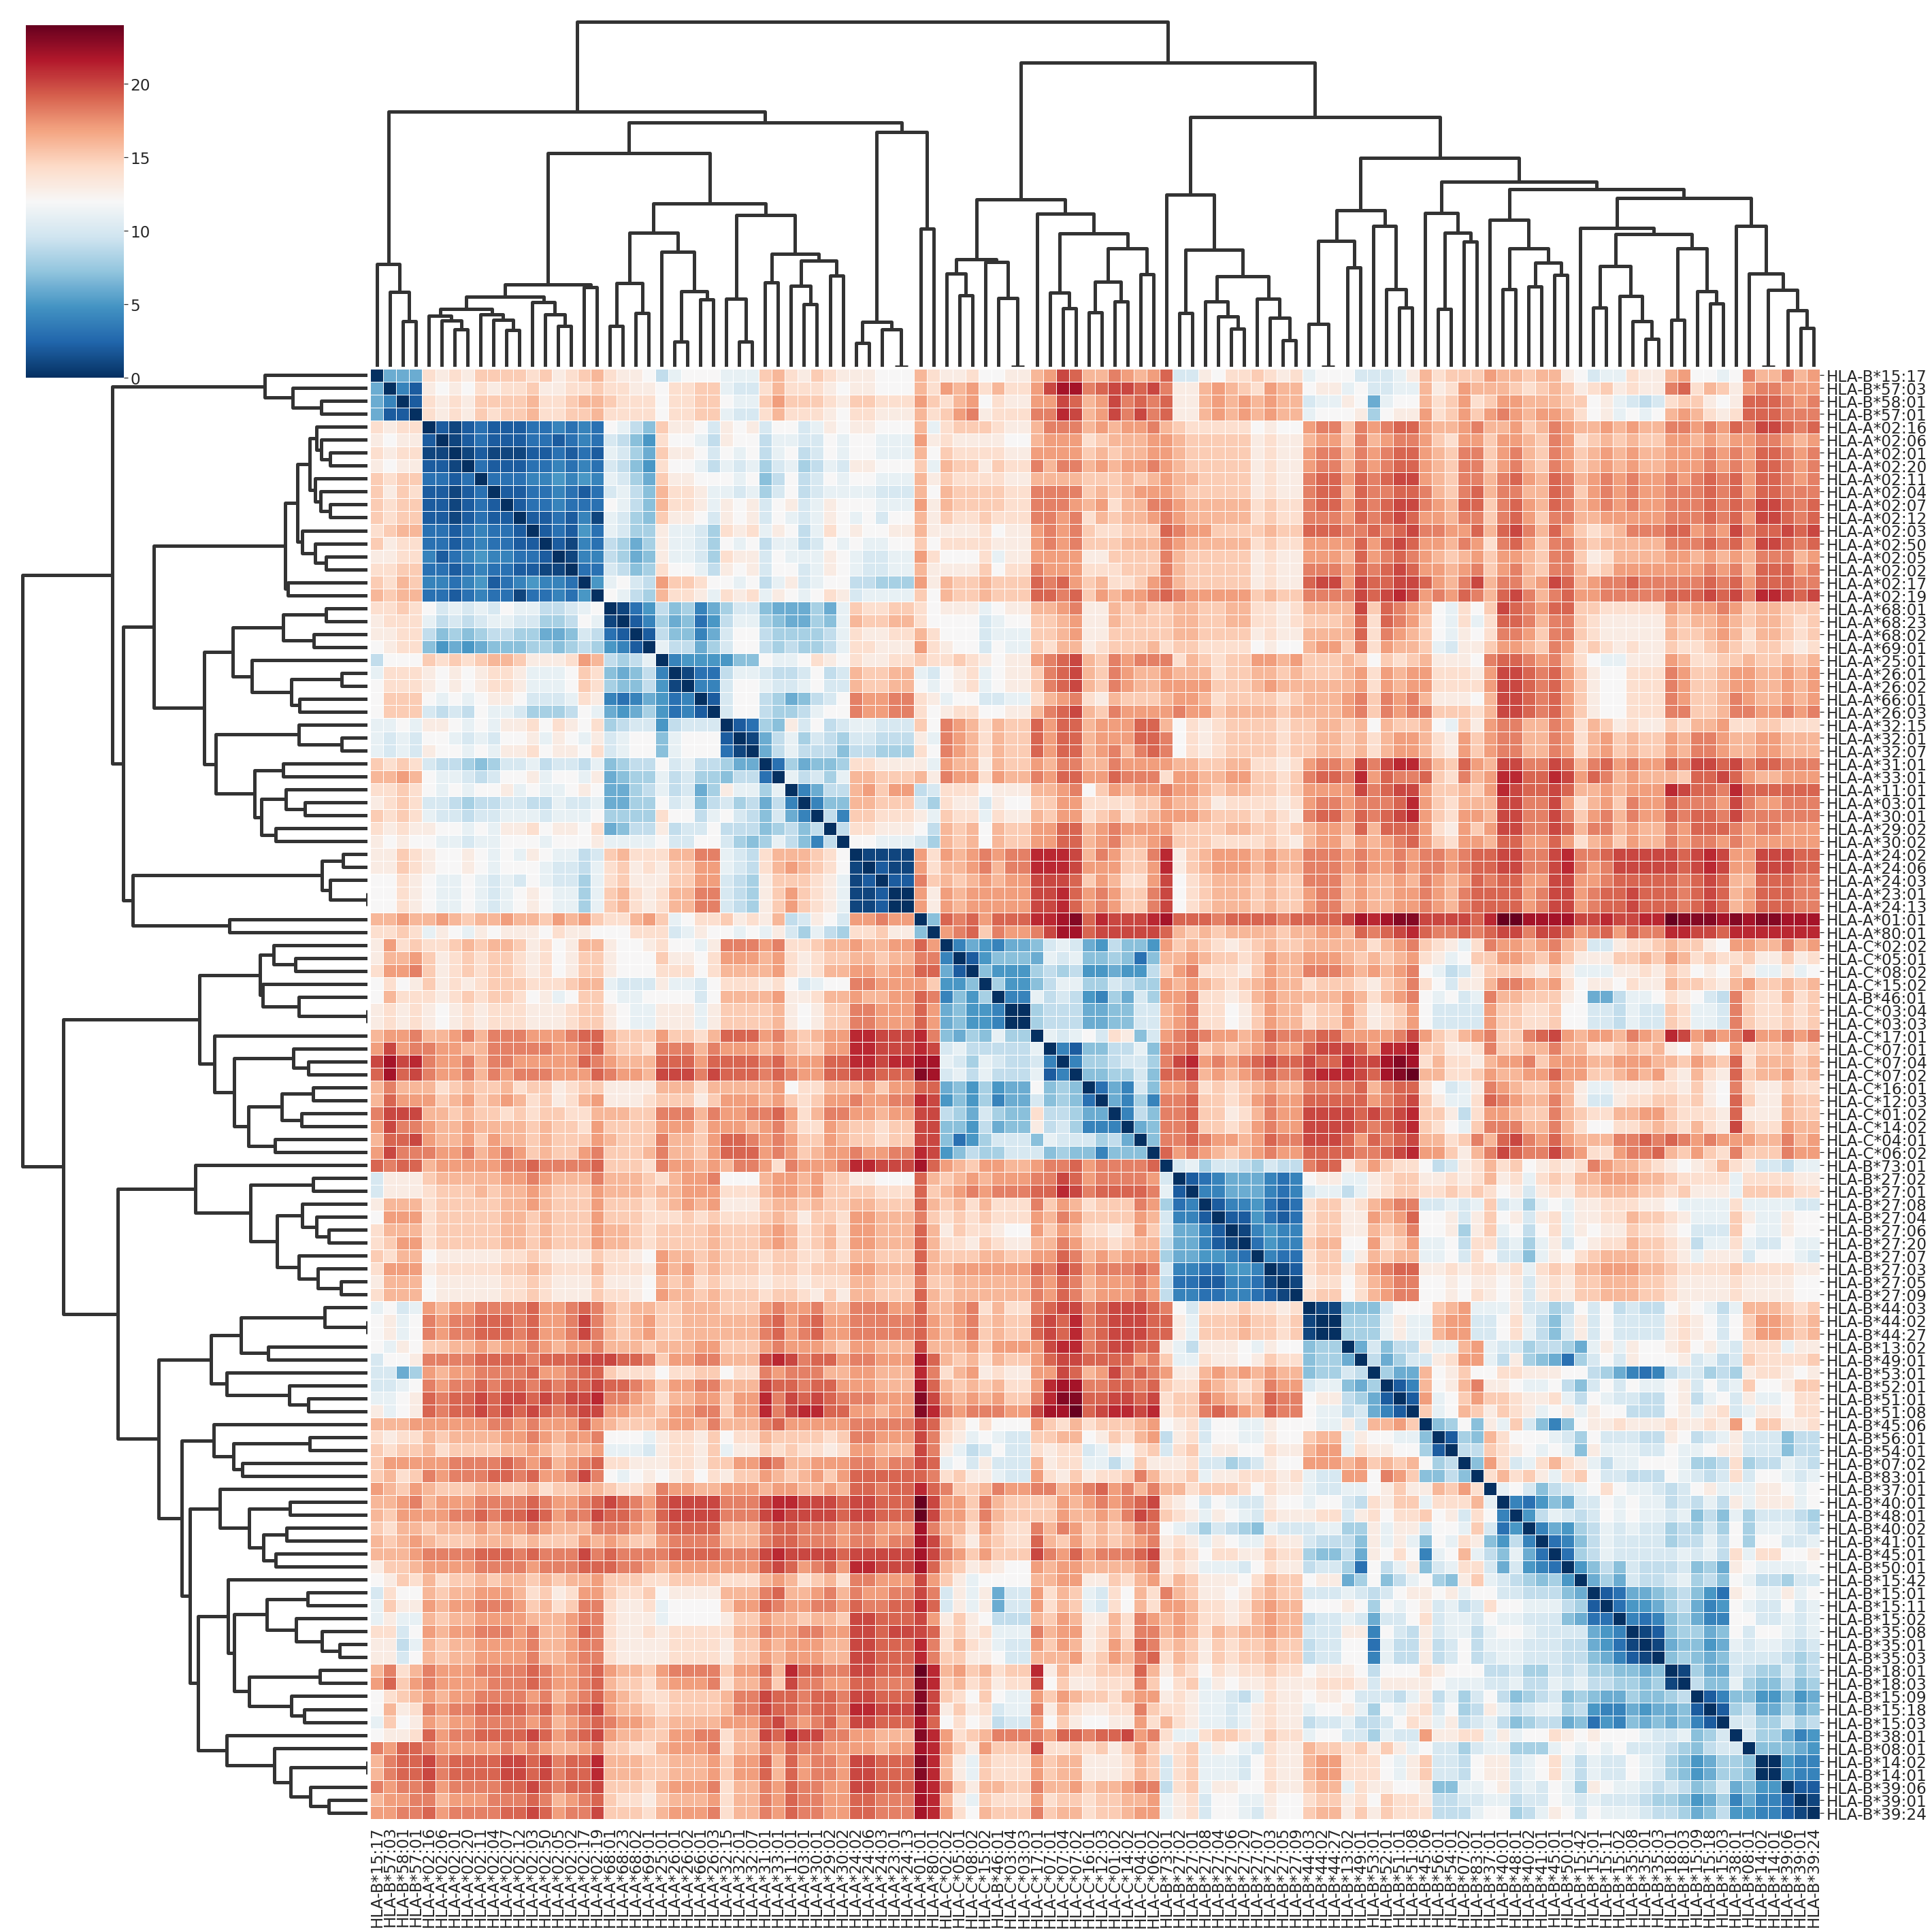

In [32]:
sn.set(font_scale=2.1)
g = sn.clustermap(tbl_text_sim, cmap='RdBu_r', linewidths=0.5, figsize=(40, 40), xticklabels=True, yticklabels=True, annot_kws={"size": 36})
for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(5)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(5)

In [33]:
attn_sim = np.array(tbl_cluster_sim).flatten()
text_sim = np.array(tbl_text_sim).flatten()


col_names = ['attn', 'text']
sim_list = [attn_sim, text_sim]

def similariy_matrix_models(a, b):
    coef = np.corrcoef(a, b)[0][1]
    return coef

matrix_1 = []
for i in sim_list:
    matrix_2 = []
    for t in sim_list:
        matrix_2.append(similariy_matrix_models(i, t))
    matrix_1.append(matrix_2)

sim = pd.DataFrame(matrix_1, columns = col_names)
sim.index = col_names
sim

attn      text
attn  1.000000  0.005804
text  0.005804  1.000000

In [153]:
Cluster0 = ['HLA-B*14:01',
 'HLA-B*14:02']
            
Cluster1 =  ['HLA-B*57:03',
 'HLA-B*57:01',
 'HLA-B*58:01']

Cluster2 = [
 'HLA-B*52:01',
 'HLA-B*51:01',
 'HLA-B*51:08',
 'HLA-B*15:09',
 'HLA-B*15:18',
 'HLA-B*35:08',
 'HLA-B*53:01',
 'HLA-B*35:01',
 'HLA-B*35:03',
 'HLA-B*38:01',
 'HLA-B*39:06',
 'HLA-B*39:01',
 'HLA-B*39:24']

Cluster3 = ['HLA-A*33:01',
 'HLA-A*11:01',
 'HLA-A*29:02']
            
            
Cluster4 = ['HLA-A*01:01',
 'HLA-A*03:01',
 'HLA-A*30:01',
 'HLA-A*30:02']

Cluster5 = ['HLA-A*80:01',
 'HLA-C*07:01',
 'HLA-A*31:01',
 'HLA-A*32:07',
 'HLA-A*32:01',
 'HLA-A*32:15']

Cluster6 = ['HLA-B*15:17',
 'HLA-A*26:02',
 'HLA-A*68:02',
 'HLA-A*25:01',
 'HLA-C*15:02',
 'HLA-A*26:01',
 'HLA-A*26:03',
 'HLA-A*66:01',
 'HLA-A*68:01',
 'HLA-A*68:23']

Cluster7 = ['HLA-B*44:03',
 'HLA-B*44:02',
 'HLA-B*44:27']

Cluster8 = [
 'HLA-B*15:03',
 'HLA-B*13:02',
 'HLA-B*15:42',
 'HLA-B*15:02',
 'HLA-B*15:01',
 'HLA-B*15:11']

Cluster9 = [ 'HLA-B*56:01',
 'HLA-B*83:01',
 'HLA-C*08:02',
 'HLA-C*02:02',
 'HLA-C*05:01',
 'HLA-C*17:01',
 'HLA-C*07:02',
 'HLA-C*07:04',
 'HLA-C*03:03',
 'HLA-C*03:04',
 'HLA-C*12:03',
 'HLA-C*16:01',
 'HLA-B*46:01',
 'HLA-B*54:01']


Cluster10 = ['HLA-C*04:01',
 'HLA-C*06:02',
 'HLA-C*14:02']
                   
            
Cluster11 =  ['HLA-B*45:01',
 'HLA-B*45:06',
 'HLA-B*37:01',
 'HLA-B*49:01',
 'HLA-B*50:01',
 'HLA-B*18:01',
 'HLA-B*18:03',
 'HLA-B*41:01',
 'HLA-B*40:01',
 'HLA-B*40:02']


Cluster12 = ['HLA-B*08:01',
 'HLA-B*27:07',
 'HLA-B*27:06',
 'HLA-B*27:20',
 'HLA-B*27:02',
 'HLA-B*27:01',
 'HLA-B*27:09',
 'HLA-B*27:05',
 'HLA-B*27:04',
 'HLA-B*27:08',
 'HLA-B*27:03',
 'HLA-B*73:01']


Cluster13 = ['HLA-A*02:20',
 'HLA-A*02:02',
 'HLA-A*02:50',
 'HLA-A*02:11',
 'HLA-A*02:04',
 'HLA-A*02:01',
 'HLA-A*02:16',
 'HLA-A*02:19',
 'HLA-A*02:03',
 'HLA-A*02:12',
 'HLA-A*02:07',
 'HLA-A*02:17']

Cluster14 = ['HLA-C*01:02',
 'HLA-A*24:03',
 'HLA-A*23:01',
 'HLA-A*24:13',
 'HLA-A*24:02',
 'HLA-A*24:06']

Cluster15 = ['HLA-B*07:02',
 'HLA-B*48:01',
 'HLA-A*69:01',
 'HLA-A*02:05',
 'HLA-A*02:06']


clusters = [Cluster0, Cluster1, Cluster2, Cluster3, Cluster4, Cluster5, Cluster6, Cluster7, Cluster8, Cluster9, Cluster10, Cluster11, Cluster12, Cluster13, Cluster14, Cluster15 ]

In [15]:
distanc_list = dict()
score_g = []

col1 = []
col2 = []

In [16]:
for HLA_1 in df_HLA.HLA:
    hla_seq_1 = list(df_HLA[df_HLA['HLA']== HLA_1].HLA_sequence)[0]
    for HLA_2 in df_HLA.HLA:
        if HLA_1 != HLA_2:
            key = HLA_1 + '_' + HLA_2
            key2 = HLA_2 + '_' + HLA_1
            if key not in list(distanc_list.keys()):
                if key2 not in list(distanc_list.keys()):
                    hla_seq_2 = list(df_HLA[df_HLA['HLA']== HLA_2].HLA_sequence)[0]
                    d = levenshtein_distance(hla_seq_1, hla_seq_2)
                    d = (34-d)/34
                    distanc_list[key] = d
                    print(HLA_1, HLA_2, ":", d)
                    score_g.append(d)
                    col1.append("Global")
                    col2.append(d)

HLA-B*15:01 HLA-C*07:01 : 0.5882352941176471
HLA-B*15:01 HLA-B*58:01 : 0.6470588235294118
HLA-B*15:01 HLA-C*04:01 : 0.5294117647058824
HLA-B*15:01 HLA-B*07:02 : 0.6764705882352942
HLA-B*15:01 HLA-A*02:03 : 0.5882352941176471
HLA-B*15:01 HLA-A*23:01 : 0.47058823529411764
HLA-B*15:01 HLA-A*31:01 : 0.47058823529411764
HLA-B*15:01 HLA-A*11:01 : 0.5294117647058824
HLA-B*15:01 HLA-B*27:05 : 0.5588235294117647
HLA-B*15:01 HLA-B*45:01 : 0.7352941176470589
HLA-B*15:01 HLA-A*32:01 : 0.5294117647058824
HLA-B*15:01 HLA-A*03:01 : 0.5294117647058824
HLA-B*15:01 HLA-A*68:01 : 0.5588235294117647
HLA-B*15:01 HLA-A*02:01 : 0.5294117647058824
HLA-B*15:01 HLA-B*13:02 : 0.6764705882352942
HLA-B*15:01 HLA-B*57:01 : 0.6470588235294118
HLA-B*15:01 HLA-A*24:02 : 0.47058823529411764
HLA-B*15:01 HLA-B*08:01 : 0.6470588235294118
HLA-B*15:01 HLA-C*05:01 : 0.6176470588235294
HLA-B*15:01 HLA-B*37:01 : 0.6470588235294118
HLA-B*15:01 HLA-A*02:04 : 0.5
HLA-B*15:01 HLA-A*01:01 : 0.4117647058823529
HLA-B*15:01 HLA-C*01:0

In [156]:
distanc_list_c = dict()
cluster_score_g = []

for cluster in clusters:
    cluster_score = []
    print("------------------")
    for HLA_1 in cluster:
        hla_seq_1 = list(df_HLA[df_HLA['HLA']== HLA_1].HLA_sequence)[0]
        for HLA_2 in cluster:
            if HLA_1 != HLA_2:
                key = HLA_1 + '_' + HLA_2
                key2 = HLA_2 + '_' + HLA_1
                if key not in list(distanc_list_c.keys()):
                    if key2 not in list(distanc_list_c.keys()):
                        hla_seq_2 = list(df_HLA[df_HLA['HLA']== HLA_2].HLA_sequence)[0]
                        dv = levenshtein_distance(hla_seq_1, hla_seq_2)
                        dv = (34-dv)/34
                        distanc_list_c[key] = dv
                        print(HLA_1, HLA_2, ":", dv)
                        cluster_score.append(dv)
    cluster_score_g.append(cluster_score)

    


------------------
HLA-B*14:01 HLA-B*14:02 : 1.0
------------------
HLA-B*57:03 HLA-B*57:01 : 0.9411764705882353
HLA-B*57:03 HLA-B*58:01 : 0.8823529411764706
HLA-B*57:01 HLA-B*58:01 : 0.9411764705882353
------------------
HLA-B*52:01 HLA-B*51:01 : 0.9411764705882353
HLA-B*52:01 HLA-B*51:08 : 0.8823529411764706
HLA-B*52:01 HLA-B*15:09 : 0.7058823529411765
HLA-B*52:01 HLA-B*15:18 : 0.6470588235294118
HLA-B*52:01 HLA-B*35:08 : 0.6470588235294118
HLA-B*52:01 HLA-B*53:01 : 0.7647058823529411
HLA-B*52:01 HLA-B*35:01 : 0.6764705882352942
HLA-B*52:01 HLA-B*35:03 : 0.6764705882352942
HLA-B*52:01 HLA-B*38:01 : 0.6764705882352942
HLA-B*52:01 HLA-B*39:06 : 0.6176470588235294
HLA-B*52:01 HLA-B*39:01 : 0.5588235294117647
HLA-B*52:01 HLA-B*39:24 : 0.5588235294117647
HLA-B*51:01 HLA-B*51:08 : 0.9411764705882353
HLA-B*51:01 HLA-B*15:09 : 0.7352941176470589
HLA-B*51:01 HLA-B*15:18 : 0.6764705882352942
HLA-B*51:01 HLA-B*35:08 : 0.7058823529411765
HLA-B*51:01 HLA-B*53:01 : 0.8235294117647058
HLA-B*51:01 H

In [157]:
# alternative

t = 0
for cluster in cluster_score_g:
    t += 1
    print(t, end = ": ")
    for c in cluster:
        col1.append("Group{}".format(t))
        col2.append(c)
    temp = np.array(cluster)
    print(round(temp.mean(),2), round(np.median(temp),3) )
    print("------")
    
d = {'Cluster':col1,'Similarity score':col2} 
df = pd.DataFrame(d, columns=['Cluster','Similarity score'])


1: 1.0 1.0
------
2: 0.92 0.941
------
3: 0.75 0.735
------
4: 0.73 0.735
------
5: 0.76 0.75
------
6: 0.69 0.676
------
7: 0.78 0.794
------
8: 0.98 0.971
------
9: 0.81 0.824
------
10: 0.74 0.735
------
11: 0.8 0.794
------
12: 0.76 0.735
------
13: 0.82 0.882
------
14: 0.92 0.912
------
15: 0.81 0.941
------
16: 0.64 0.574
------


Blues


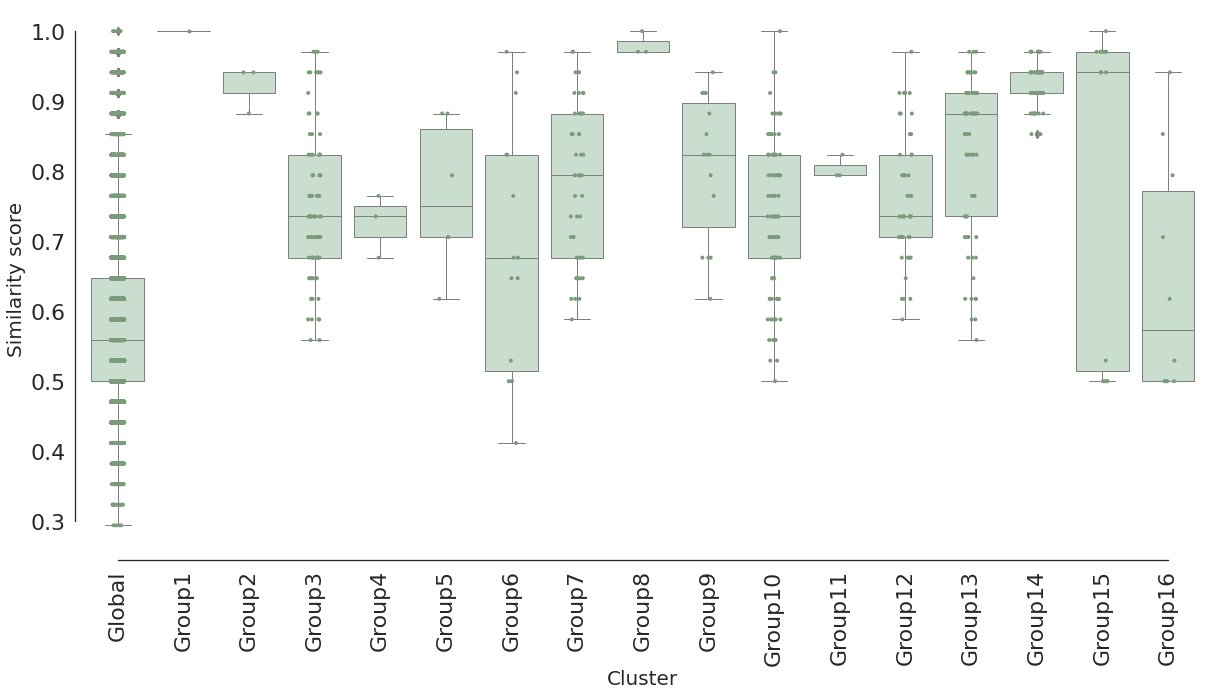

In [162]:
for palette in ['Blues']:

    print(palette)
    fig, ax = plt.subplots(figsize=(20,10))
    metric = 'AUC01'

    sn.set(style='white')

    #sn.set(style="ticks")

    sn.boxplot(x="Cluster", y="Similarity score", data=df,
                color='#c7e1cd', linewidth=1)
    

    ax = sn.stripplot(x="Cluster", y="Similarity score", data=df,
                  color='#7a9c7b', size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu
    
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=20)

    for ax in plt.gcf().axes:
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=20)

    sn.set(font_scale=2)

    sn.despine(offset=10, trim=True)
    
    plt.xticks(rotation=90)

    plt.show()
    

Blues


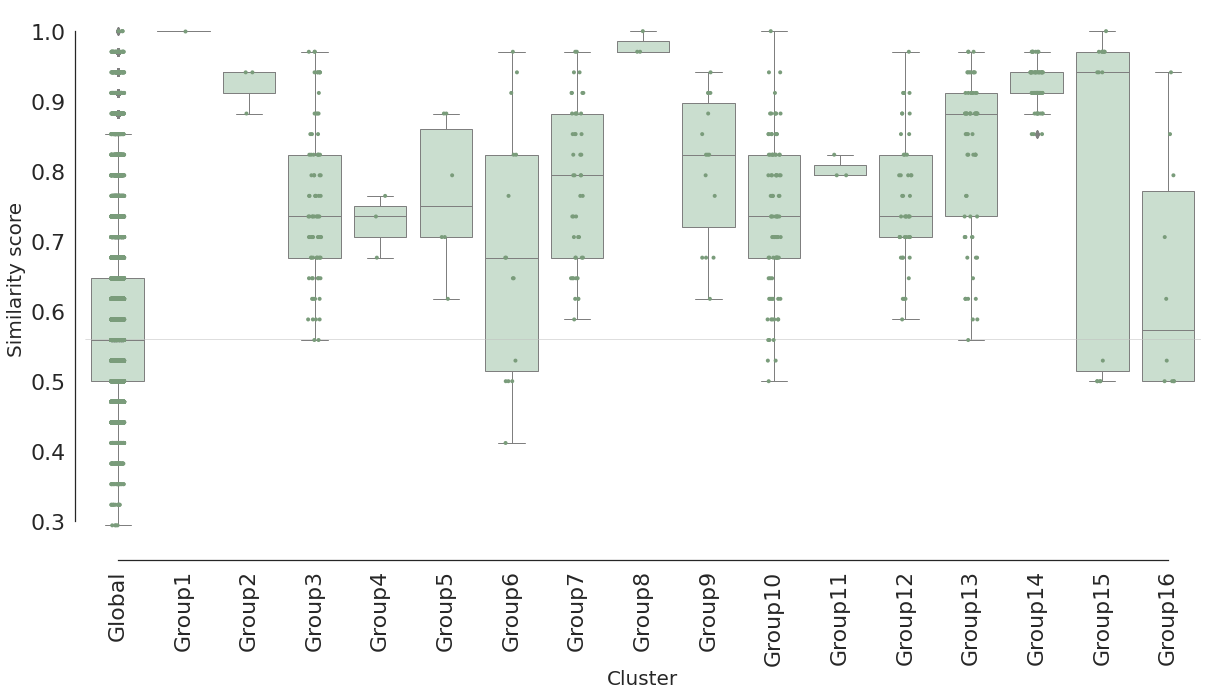

In [164]:
for palette in ['Blues']:

    print(palette)
    fig, ax = plt.subplots(figsize=(20,10))
    metric = 'AUC01'

    sn.set(style='white')

    #sn.set(style="ticks")

    sn.boxplot(x="Cluster", y="Similarity score", data=df,
                color='#c7e1cd', linewidth=1)
    

    ax = sn.stripplot(x="Cluster", y="Similarity score", data=df,
                  color='#7a9c7b', size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu
    
    ax.axhline(0.56, color='#bfbfbf', linewidth=0.5)
    

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=20)

    for ax in plt.gcf().axes:
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=20)

    sn.set(font_scale=2)

    sn.despine(offset=10, trim=True)
    
    plt.xticks(rotation=90)

    
    plt.show()

Blues


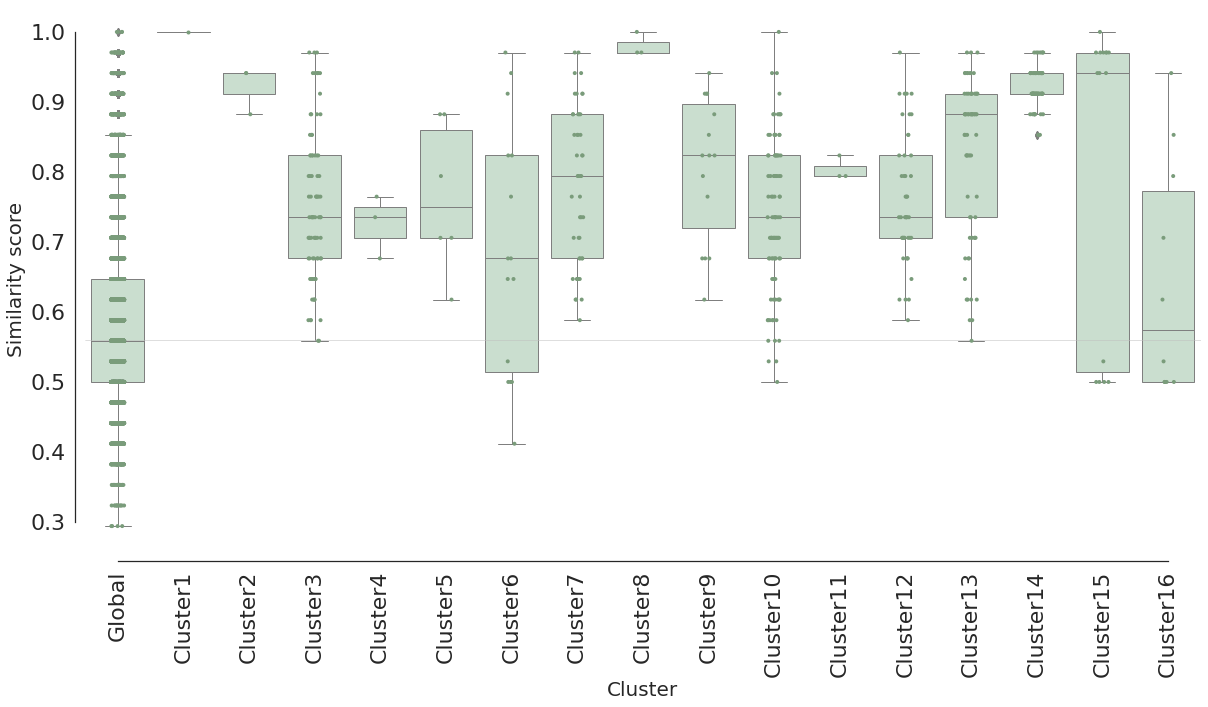

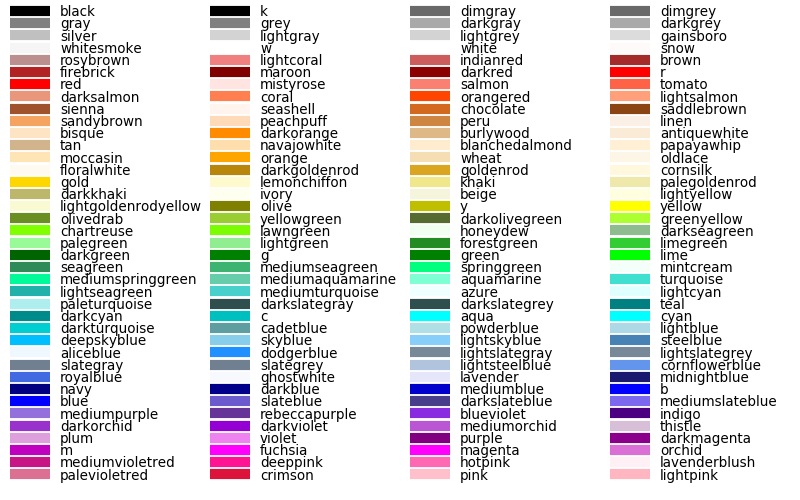

In [41]:
#Analyse the pairwise similarity of the MHC pseduod seqeunces from this printed output;

HLA-B*15:01 HLA-C*07:01 : 0.5882352941176471
HLA-B*15:01 HLA-B*58:01 : 0.6470588235294118
HLA-B*15:01 HLA-C*04:01 : 0.5294117647058824
HLA-B*15:01 HLA-B*07:02 : 0.6764705882352942
HLA-B*15:01 HLA-A*02:03 : 0.5882352941176471
HLA-B*15:01 HLA-A*23:01 : 0.47058823529411764
HLA-B*15:01 HLA-A*31:01 : 0.47058823529411764
HLA-B*15:01 HLA-A*11:01 : 0.5294117647058824
HLA-B*15:01 HLA-B*27:05 : 0.5588235294117647
HLA-B*15:01 HLA-B*45:01 : 0.7352941176470589
HLA-B*15:01 HLA-A*32:01 : 0.5294117647058824
HLA-B*15:01 HLA-A*03:01 : 0.5294117647058824
HLA-B*15:01 HLA-A*68:01 : 0.5588235294117647
HLA-B*15:01 HLA-A*02:01 : 0.5294117647058824
HLA-B*15:01 HLA-B*13:02 : 0.6764705882352942
HLA-B*15:01 HLA-B*57:01 : 0.6470588235294118
HLA-B*15:01 HLA-A*24:02 : 0.47058823529411764
HLA-B*15:01 HLA-B*08:01 : 0.6470588235294118
HLA-B*15:01 HLA-C*05:01 : 0.6176470588235294
HLA-B*15:01 HLA-B*37:01 : 0.6470588235294118
HLA-B*15:01 HLA-A*02:04 : 0.5
HLA-B*15:01 HLA-A*01:01 : 0.4117647058823529
HLA-B*15:01 HLA-C*01:0

Blues


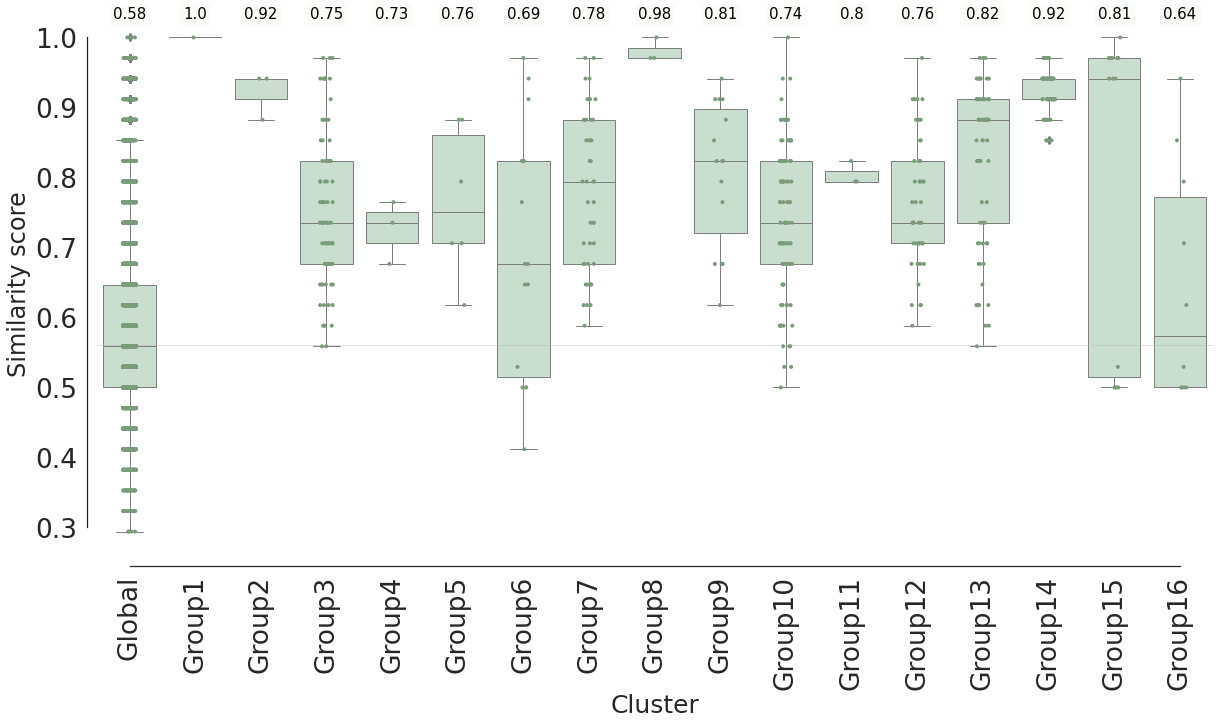

In [57]:
#Print the 'mean' value above the boxplots:

for palette in ['Blues']:

    print(palette)
    fig, ax = plt.subplots(figsize=(20,10))
    metric = 'AUC01'

    sn.set(style='white')

    #sn.set(style="ticks")

    sn.boxplot(x="Cluster", y="Similarity score", data=df,
                color='#c7e1cd', linewidth=1)
    

    ax = sn.stripplot(x="Cluster", y="Similarity score", data=df,
                  color='#7a9c7b', size=4, edgecolor="gray", split=True) #PuBuGn, YlGnBu
    
    ax.axhline(0.56, color='#bfbfbf', linewidth=0.5)
    

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=25)

    for ax in plt.gcf().axes:
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=24)

    sn.set(font_scale=2.4)

    sn.despine(offset=10, trim=True)
    
    plt.xticks(rotation=90)
    
    lines = ax.get_lines()
    categories = ax.get_xticks()

    sn.set(style='white')
    
    tt = 0
    for cat in categories:
        # every 4th line at the interval of 6 is median line
        # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
        y = round(lines[4+cat*6].get_ydata()[0],1) 

        ax.text(
            cat, 
            1.032579, 
            f'{mean_l[tt]}', 
            ha='center', 
            va='center',  
            size=15,
            color='black',
            bbox=dict(facecolor='#F9FCF8'))
        tt += 1
    sn.set(style='white')
    plt.show()